Initialize libaries & Model

In [1]:
#Initialize libaries 
from __future__ import print_function
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import math

import torch.backends.cudnn as cudnn
import os
import argparse

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
  print("Using GPU.")
else: 
  print("Using CPU.")

Using GPU.


In [2]:
# Set fixed random number seed
torch.cuda.manual_seed(999)
torch.manual_seed(999)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# This is a basic densenet model definition.

class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# This creates a densenet model with basic settings for cifar.
def densenet_cifar():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=12)

In [4]:
#change the directory to load your own pretrained model
print('==> Loading saved model for CIFAR..')
cifar_model = densenet_cifar().to(device)
cifar_model.load_state_dict(torch.load('/hdd/projects/CHIA_FYP/Framework/Models/densenet_25_Epoch.pth'))
cifar_model.eval()

==> Loading saved model for CIFAR..


DenseNet(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

Instantiate Classes

In [10]:
#Instantiate classes of Cifar10 Dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Instantiate DataSet

In [5]:
# CIFAR10 dataloader declaration

print('==> Preparing data..')

# The standard output of the torchvision CIFAR data set is [0,1] range, which
# is what we want for later processing. All we need for a transform, is to 
# translate it to tensors.

# we first download the train and test datasets if necessary and then load them into pytorch dataloaders
cifar_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar_train_loader = torch.utils.data.DataLoader(cifar_train_dataset, batch_size=128, shuffle=True, num_workers=1)

cifar_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
cifar_test_loader = torch.utils.data.DataLoader(cifar_test_dataset, batch_size=100, shuffle=False, num_workers=1)

# these are the output categories from the CIFAR dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


Function to test what classes performed well

In [14]:
def testClasses(folder):
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    with torch.no_grad():
        for data in folder:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            output = cifar_model(images)
            _, predicted = torch.max(output, 1)
            correct = (predicted == labels).squeeze()
            for i in range(100):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    for i in range(len(classes)):
        accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print('Accuracy of %5s : %.2f %%' % (classes[i], accuracy))

testClasses(cifar_test_loader)

Accuracy of plane : 86.40 %
Accuracy of   car : 95.00 %
Accuracy of  bird : 79.20 %
Accuracy of   cat : 66.10 %
Accuracy of  deer : 87.90 %
Accuracy of   dog : 69.90 %
Accuracy of  frog : 88.90 %
Accuracy of horse : 76.00 %
Accuracy of  ship : 86.20 %
Accuracy of truck : 79.70 %


FGSM Attack Function & Pixel Difference

In [6]:
# Fast Gradient Singed Method attack (FGSM)
#Model is the trained model for the target dataset
#target is the ground truth label of the image
#epsilon is the hyper parameter which shows the degree of perturbation

def fgsm_attack(model, image, target, epsilon):
    # Set requires_grad attribute of tensor. Important for Attack
    image.requires_grad = True

    # Forward pass the data through the model
    output = model(image)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability(the prediction of the model)
    
    
   
    # If the initial prediction is already wrong, dont bother attacking
    if init_pred[0].item() != target[0].item():
    #if init_pred.item() != target.item():
        return image
    # Calculate the loss
    loss = F.nll_loss(output, target)
    # Zero all existing gradients
    model.zero_grad()
    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect datagrad
    data_grad = image.grad.data
    
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image

#This is where we test the effect of the attack on the trained model
#model is the pretrained model on your dataset
#test_loader contains the test dataset
#other parameters are set based on the type of the attack

def attack_test(model, device, test_loader, epsilon, iters, attack='fgsm', alpha=1 ):

    # Accuracy counter. accumulates the number of correctly predicted exampels
    correct = 0
    adv_examples = []  # a list to save some of the successful adversarial examples for visualizing purpose
    orig_examples = []  # this list keeps the original image before manipulation corresponding to the images in adv_examples list for comparing purpose


    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        # print(target)
        # print(target[0].item())
        # print("next")
        data, target = data.to(device), target.to(device)
        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability (model prediction of the image)
       
      
        
        # Call the Attack
        if attack == 'fgsm':
            perturbed_data = fgsm_attack(model, data, target, epsilon=epsilon )
        else:
            perturbed_data = ill_attack(model, data, target, epsilon, alpha, iters)
        

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        #target refers to the ground truth label
        #init_pred refers to the model prediction of the original image
        #final_pred refers to the model prediction of the manipulated image
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability (model prediction of the perturbed image)
        if final_pred[0].item() == target[0].item():  #perturbation hasn't affected the classification
            correct += 1
            
            # Special case for saving 0 epsilon examples which is equivalent to no adversarial attack
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                orig_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred[0].item(), final_pred[0].item(), adv_ex) )
                orig_examples.append( (target[0].item(), init_pred[0].item(), orig_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                orig_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred[0].item(), final_pred[0].item(), adv_ex) )
                orig_examples.append( (target[0].item(), init_pred[0].item(), orig_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial examples and their corresponding original images
    return final_acc, adv_examples, orig_examples

In [15]:
fgsm_epsilons = [ .05] # values for epsilon hyper-parameter for FGSM attack
#FGSM attack
cifar_fgsm_accuracies = [] #list to keep the model accuracy after attack for each epsilon value
cifar_fgsm_examples = [] # list to collect adversarial examples returned from the attack_test function for every epsilon values
cifar_fgsm_orig_examples = [] #list to collect original images corresponding the collected adversarial examples

# Run test for each epsilon
for eps in fgsm_epsilons:
    acc, ex, orig = attack_test(cifar_model, device, cifar_test_loader, eps, attack='fgsm', alpha=1, iters=0)
    cifar_fgsm_accuracies.append(acc)
    cifar_fgsm_examples.append(ex)
    cifar_fgsm_orig_examples.append(orig)

Epsilon: 0.05	Test Accuracy = 9 / 100 = 0.09


In [25]:
from torchvision.transforms import (CenterCrop, Compose, Normalize, Resize,
                                    ToTensor)
def to_array(tensor):
    """Convert torch.Tensor to np.ndarray.

    Parameters
    ----------
    tensor : torch.Tensor
        Tensor of shape `(1, 3, *, *)` representing one sample batch of images.

    Returns
    -------
    arr : np.ndarray
        Array of shape `(*, *, 3)` representing an image that can be plotted
        directly.
    """
    tensor_ = tensor.squeeze()

    # unnormalize_transform = Compose([Normalize(mean=[0, 0, 0],
    #                                            std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
    #                                  Normalize(mean=[-0.485, -0.456, -0.406],
    #                                            std=[1, 1, 1])])
    # arr_ = unnormalize_transform(tensor_)
    arr = tensor_.permute(1, 2, 0).detach().numpy()

    return arr

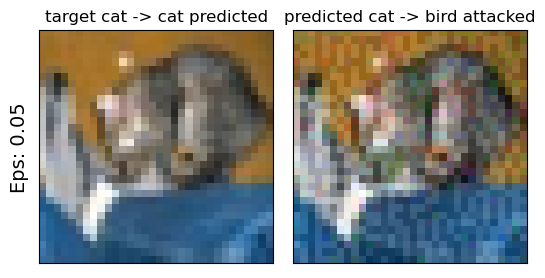

In [28]:
# Plot several examples vs their adversarial samples at each epsilon for fgms attack
cnt = 0
# 8 is the separation between images
# 20 is the size of the printed image
plt.figure(figsize=(8,20))
for i in range(len(fgsm_epsilons)):
    orig_arr = []
    new_arr = []
    for j in range(2):
        cnt += 1
        plt.subplot(len(fgsm_epsilons),3,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j==0:
            plt.ylabel("Eps: {}".format(fgsm_epsilons[i]), fontsize=14)
            orig,adv,ex = cifar_fgsm_orig_examples[i][0]
            # orig_arr = to_array(ex[0])
            plt.title("target "+"{} -> {}".format(classes[orig], classes[adv])+ " predicted")
            plt.imshow(ex[0].transpose(1,2,0), cmap="gray")
        elif j==1:
            orig,adv,ex = cifar_fgsm_examples[i][0]
            # new_arr = to_array(ex[0])
            plt.title("predicted "+"{} -> {}".format(classes[orig], classes[adv])+ " attacked")
            plt.imshow(ex[0].transpose(1,2,0), cmap="gray")
#         else: #j=2
#             # Assuming orig_arr and new_arr have the same shape
#             diff_arr = np.abs(orig_arr - new_arr).mean(axis=-1)
#             diff_arr = diff_arr / diff_arr.max()
#             diff_arr_scaled = (diff_arr - diff_arr.min()) / (diff_arr.max() - diff_arr.min())

#             plt.title("predicted "+"{} -> {}".format(classes[orig], classes[adv])+ " Difference")
#             plt.imshow(diff_arr_scaled , cmap = "gray")
plt.tight_layout()
plt.show()

In [23]:
tensor1 = torch.from_numpy(cifar_fgsm_examples[0][0][2])
for x in range(8) :
              im = torch.narrow(tensor1,0,x,1) #seperate into 100 images [1,3,32,32]
              numpy_im = im.squeeze().numpy()
              transposed_im = numpy_im.transpose(1,2,0)
              # plt.imshow(transposed_im, cmap="gray")
              # plt.show()
              if(x == 6): #first split image appended to modified_end
                saved_tensor = im #for testing purposes
                # modified_end = attackingfunc_display(im,classesINT)
                # print(saved_tensor.size())
                exit

tensor2 = torch.from_numpy(cifar_fgsm_orig_examples[0][0][2])
for x in range(8) :
              im = torch.narrow(tensor2,0,x,1) #seperate into 100 images [1,3,32,32]
              numpy_im = im.squeeze().numpy()
              transposed_im = numpy_im.transpose(1,2,0)
              # plt.imshow(transposed_im, cmap="gray")
              # plt.show()
              if(x == 6): #first split image appended to modified_end
                saved_tensor2 = im #for testing purposes
                # modified_end = attackingfunc_display(im,classesINT)
                # print(saved_tensor2.size())
                exit

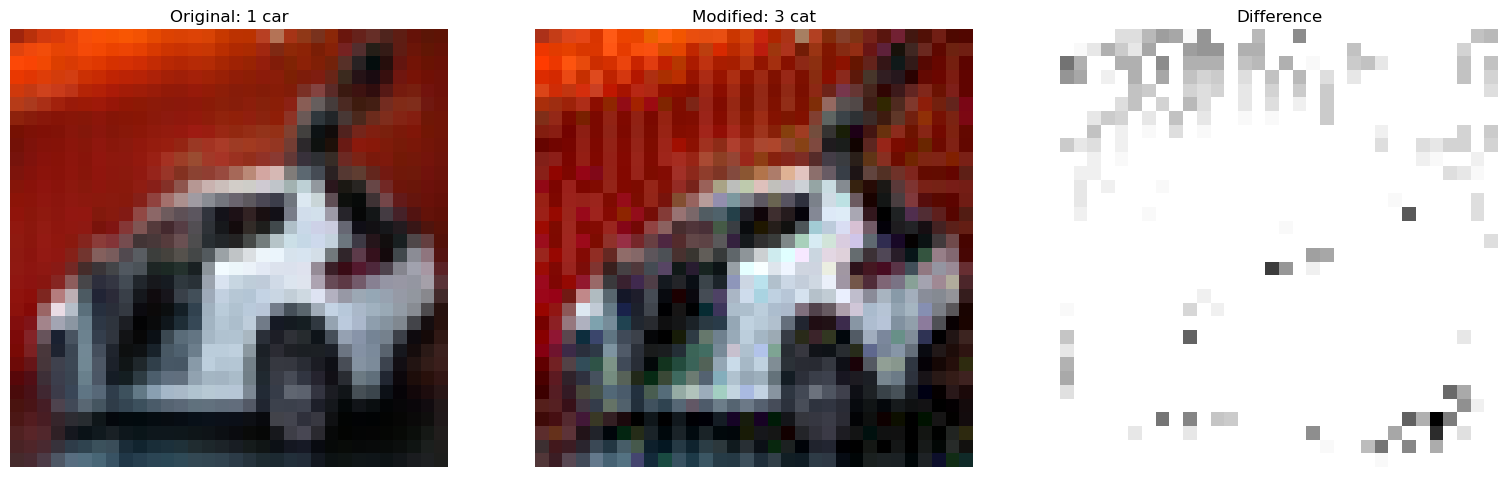

In [26]:
_, (ax_orig, ax_new, ax_diff) = plt.subplots(1, 3, figsize=(19.20,10.80))
  # saveImage2(tensor , '/content/drive/MyDrive/Colab Notebooks/Resnet50GradCamVsPixelDiff/OriginalPlane.jpg')
  # saveImage2(new_tensor , '/content/drive/MyDrive/Colab Notebooks/Resnet50GradCamVsPixelDiff/ModifiedPlane.jpg')
# torch.from_numpy(transposed_im2)
# torch.from_numpy(transposed_im1)

output1 = cifar_model(saved_tensor2.to(device))
orig_prediction = output1.max(1, keepdim=True)[1] # get the index of the max log-probability (model prediction of the image)
output2 = cifar_model(saved_tensor.to(device))
new_prediction = output2.max(1, keepdim=True)[1] # get the index of the max log-probability (model prediction of the image)

arr = to_array(saved_tensor2)
new_arr = to_array(saved_tensor)
diff_arr = np.abs(arr - new_arr).mean(axis=-1)
diff_arr = diff_arr / diff_arr.max()


ax_orig.grid(False)
ax_orig.imshow(arr)
ax_new.grid(False)
ax_new.imshow(new_arr)
ax_diff.imshow(diff_arr, cmap="gray")

ax_orig.axis("off")
ax_new.axis("off")
ax_diff.axis("off")

ax_orig.set_title(f"Original: {orig_prediction.item()} " + classes[orig_prediction])
ax_new.set_title(f"Modified: {new_prediction.item()} " + classes[new_prediction])
ax_diff.set_title("Difference")

plt.savefig("res_1.png")

Function for creation of adversarial test Folder

In [ ]:
# import os.path
# from os import path
# from PIL import Image

# def addtoFile(): #createowndataset

#   if path.exists('/hdd/projects/CHIA_FYP/Framework/Models/Dataset') == False:
#     print("no exist FGSM folder")
#     os.mkdir('/content/drive/MyDrive/FGSM')
#     print("Created FGSM folder")
#   if path.exists('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/plane') == False:
#     os.mkdir('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/plane')
#   if path.exists('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/car') == False:
#     os.mkdir('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/car')
#   if path.exists('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/bird') == False:
#     os.mkdir('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/bird')
#   if path.exists('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/cat') == False:
#     os.mkdir('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM2/cat')
#   if path.exists('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/deer') == False:
#     os.mkdir('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/deer')
#   if path.exists('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/dog') == False:
#     os.mkdir('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/dog')
#   if path.exists('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/frog') == False:
#     os.mkdir('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/frog')
#   if path.exists('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/horse') == False:
#     os.mkdir('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/horse')
#   if path.exists('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/ship') == False:
#     os.mkdir('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/ship')
#   if path.exists('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/truck') == False:
#     os.mkdir('/hdd/projects/CHIA_FYP/Framework/Models/Dataset/FGSM/truck')


# addtoFile()


import os.path
from os import path
from PIL import Image

def addtoFile(dir = "/hdd/projects/CHIA_FYP/Framework/Dataset/DenseNetDataset/FGSMOnDenseNet/"): #createowndataset

  if path.exists(dir) == False:
    print("no exist FGSM folder")
    os.mkdir(dir)
    print("Created FGSM folder")
  if path.exists(dir + '/plane2') == False:
    os.mkdir(dir + '/plane2')
  if path.exists(dir + '/car2') == False:
    os.mkdir(dir + '/car2')
  if path.exists(dir + '/bird2') == False:
    os.mkdir(dir + '/bird2')
  if path.exists(dir + '/cat2') == False:
    os.mkdir(dir + '/cat2')
  if path.exists(dir + '/deer2') == False:
    os.mkdir(dir + '/deer2')
  if path.exists(dir + '/dog2') == False:
    os.mkdir(dir + '/dog2')
  if path.exists(dir + '/frog2') == False:
    os.mkdir(dir +  '/frog2')
  if path.exists(dir + '/horse2') == False:
    os.mkdir(dir +  '/horse2')
  if path.exists(dir +  '/ship2') == False:
    os.mkdir(dir +  '/ship2')
  if path.exists(dir +  '/truck2') == False:
    os.mkdir(dir +  '/truck2')


addtoFile()

In [29]:
from PIL import Image
import PIL

def saveImage(orig_prediction,tensor , classesINT,dir):

  # Unnormalize_tensor = Unnormalize(tensor) #unnormalize tensor
  Unnormalize_tensor = torch.squeeze(tensor) #get rid of dim 1 . [1,32,32,3]
  test  = transforms.Compose([transforms.ToPILImage()]) #convert to PIL Image
  img = test(Unnormalize_tensor)
  # arr = to_array(Unnormalize_tensor) #convert tensor to arr  (need to check) this causes 2 times unnormalizing
  predict = classes[orig_prediction]
  # test = '/content/drive/MyDrive/FGSM2/'
  test = dir
  out = test + predict + '2'  #/content/drive/MyDrive/FGSM/dog
  if('plane' == predict):
    run_num = classesINT[0] #get counter for img no
    image_number= out+ '/' + classes[orig_prediction] +  str(run_num) + '.jpg' #/content/drive/MyDrive/FGSM/dog/dog0
    classesINT[0]+=1
    img.save(image_number, 'JPEG')
  if('car' == predict):
    run_num = classesINT[1] #get counter for img no
    image_number= out+ '/' + classes[orig_prediction] +  str(run_num) + '.jpg' #/content/drive/MyDrive/FGSM/dog/dog0
    classesINT[1]+=1
    img.save(image_number, 'JPEG')
  if('bird' == predict):
    run_num = classesINT[2] #get counter for img no
    image_number= out+ '/' + classes[orig_prediction] +  str(run_num) + '.jpg' #/content/drive/MyDrive/FGSM/dog/dog0
    classesINT[2]+=1
    img.save(image_number, 'JPEG')
  if('cat' == predict):
    run_num = classesINT[3] #get counter for img no
    image_number= out+ '/' + classes[orig_prediction] +  str(run_num) + '.jpg' #/content/drive/MyDrive/FGSM/dog/dog0
    classesINT[3]+=1
    img.save(image_number, 'JPEG')
  if('deer' == predict):
    run_num = classesINT[4] #get counter for img no
    image_number= out+ '/' + classes[orig_prediction] +  str(run_num) + '.jpg' #/content/drive/MyDrive/FGSM/dog/dog0
    classesINT[4]+=1
    img.save(image_number, 'JPEG')
  if('dog' == predict):
    run_num = classesINT[5] #get counter for img no
    image_number= out+ '/' + classes[orig_prediction] +  str(run_num) + '.jpg' #/content/drive/MyDrive/FGSM/dog/dog0
    classesINT[5]+=1
    img.save(image_number, 'JPEG')
  if('frog' == predict):
    run_num = classesINT[6] #get counter for img no
    image_number= out+ '/' + classes[orig_prediction] +  str(run_num) + '.jpg' #/content/drive/MyDrive/FGSM/dog/dog0
    classesINT[6]+=1
    img.save(image_number, 'JPEG')
  if('horse' == predict):
    run_num = classesINT[7] #get counter for img no
    image_number= out+ '/' + classes[orig_prediction] +  str(run_num) + '.jpg' #/content/drive/MyDrive/FGSM/dog/dog0
    classesINT[7]+=1
    img.save(image_number, 'JPEG')
  if('ship' == predict):
    run_num = classesINT[8] #get counter for img no
    image_number= out+ '/' + classes[orig_prediction] +  str(run_num) + '.jpg' #/content/drive/MyDrive/FGSM/dog/dog0
    classesINT[8]+=1
    img.save(image_number, 'JPEG')
  if('truck' == predict):
    run_num = classesINT[9] #get counter for img no
    image_number= out+ '/' + classes[orig_prediction] +  str(run_num) + '.jpg' #/content/drive/MyDrive/FGSM/dog/dog0
    classesINT[9]+=1
    img.save(image_number, 'JPEG')

In [30]:
# Fast Gradient Singed Method attack (FGSM)
#Model is the trained model for the target dataset
#target is the ground truth label of the image
#epsilon is the hyper parameter which shows the degree of perturbation

def fgsm_attack(model, image, target, epsilon):
    # Set requires_grad attribute of tensor. Important for Attack
    image.requires_grad = True

    # Forward pass the data through the model
    output = model(image)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability(the prediction of the model)



    # If the initial prediction is already wrong, dont bother attacking
    if init_pred[0].item() != target[0].item():
    #if init_pred.item() != target.item():
        return image
    # Calculate the loss
    loss = F.nll_loss(output, target)
    # Zero all existing gradients
    model.zero_grad()
    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect datagrad
    data_grad = image.grad.data

    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [ ]:
perturbed_data = fgsm_attack(cifar_model, data, target, epsilon=epsilon )

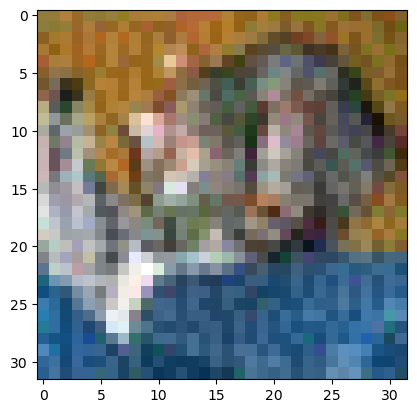

predicted :  cat
Label :  cat
3
3


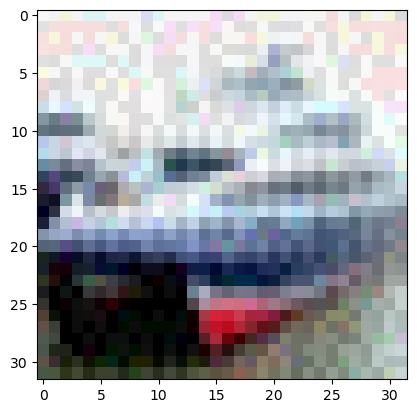

predicted :  ship
Label :  ship
8
8


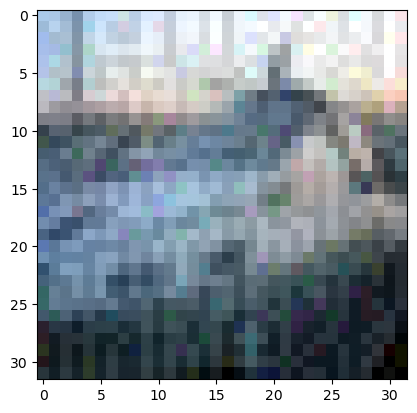

predicted :  ship
Label :  ship
8
8


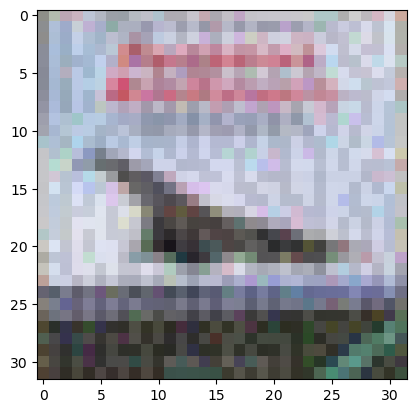

predicted :  plane
Label :  plane
0
0


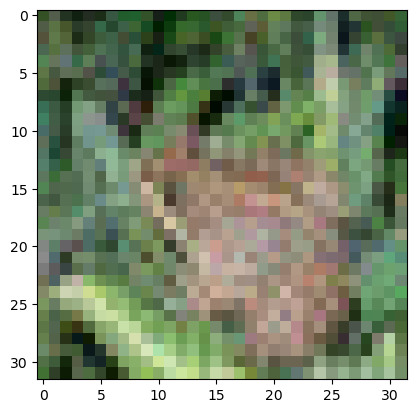

predicted :  frog
Label :  frog
6
6


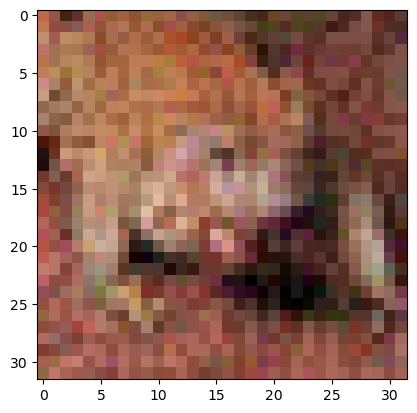

predicted :  frog
Label :  frog
6
6


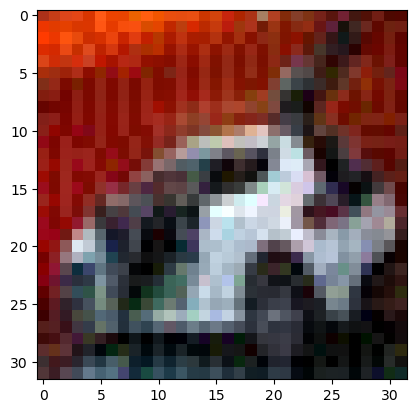

predicted :  car
Label :  car
1
1


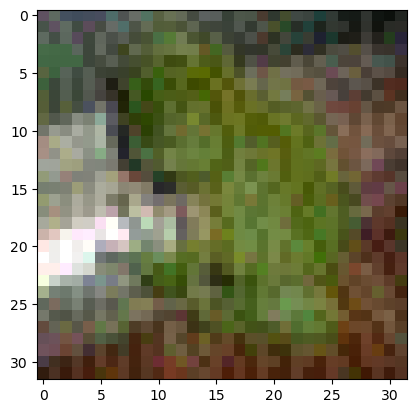

predicted :  frog
Label :  frog
6
6


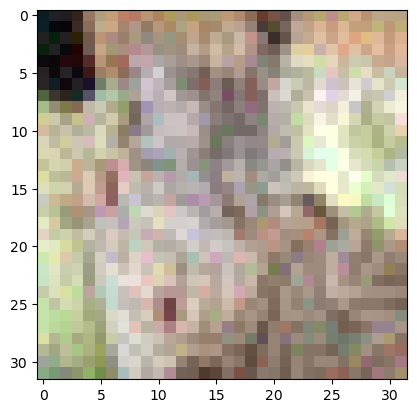

predicted :  cat
Label :  cat
3
3


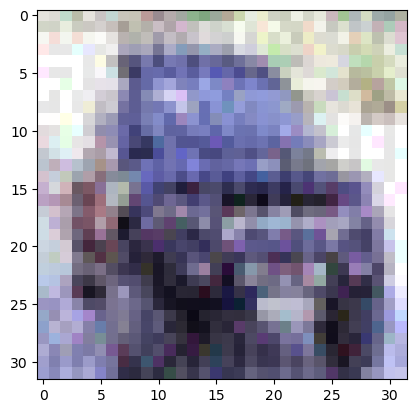

predicted :  car
Label :  car
1
1


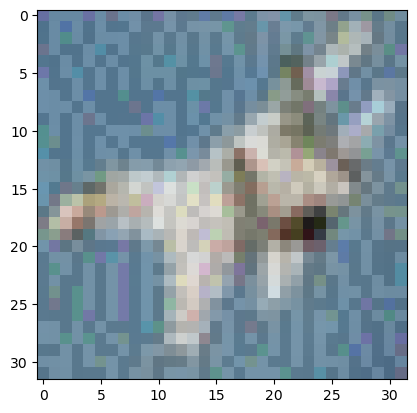

predicted :  plane
Label :  plane
0
0


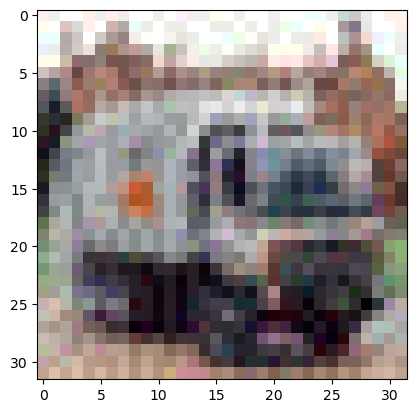

predicted :  truck
Label :  truck
9
9


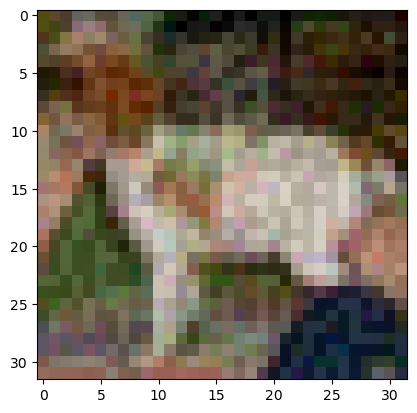

predicted :  dog
Label :  dog
5
5


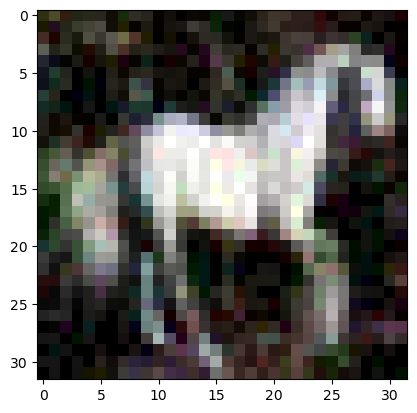

predicted :  horse
Label :  horse
7
7


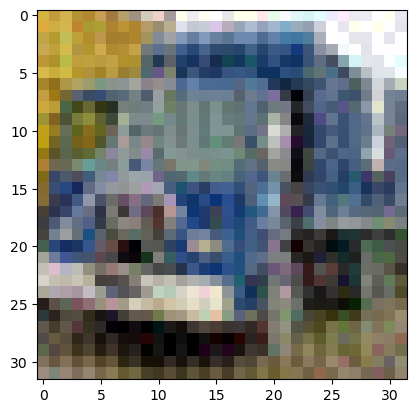

predicted :  truck
Label :  truck
9
9


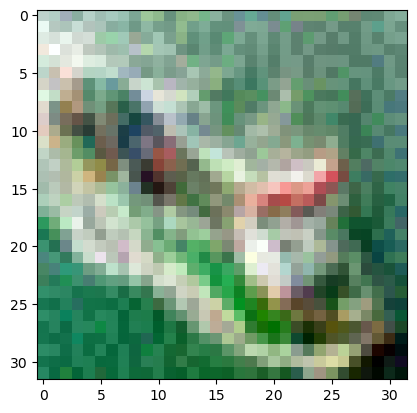

predicted :  ship
Label :  ship
8
8


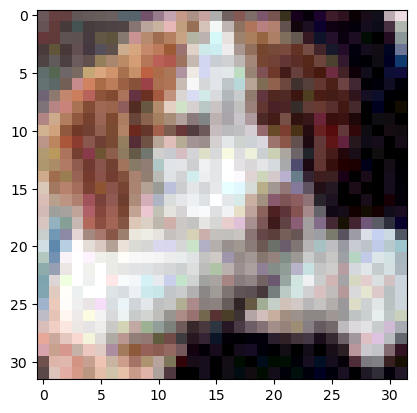

predicted :  dog
Label :  dog
5
5


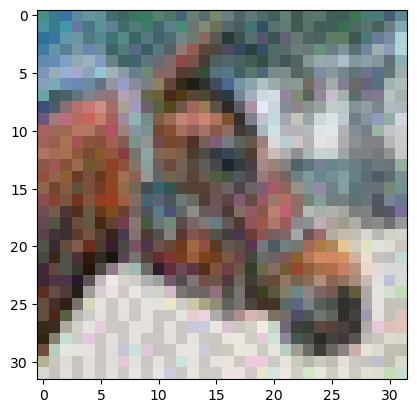

predicted :  horse
Label :  horse
7
7


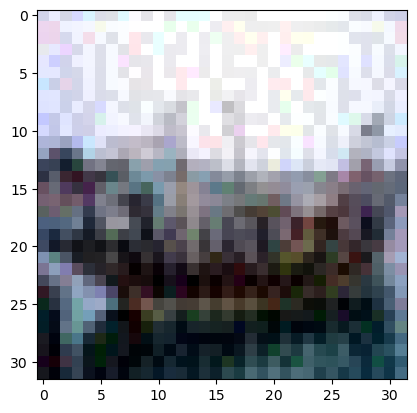

predicted :  ship
Label :  ship
8
8


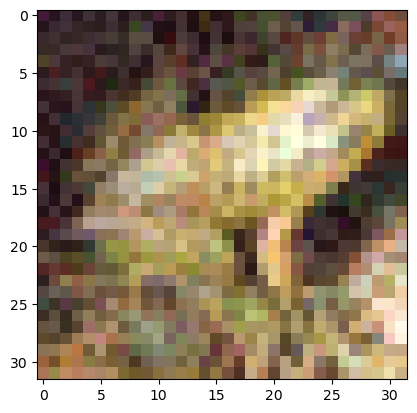

predicted :  frog
Label :  frog
6
6


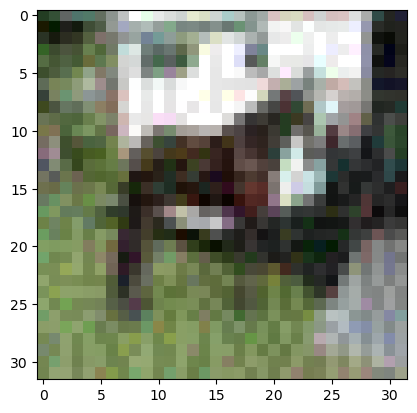

predicted :  truck
Label :  horse
9
7


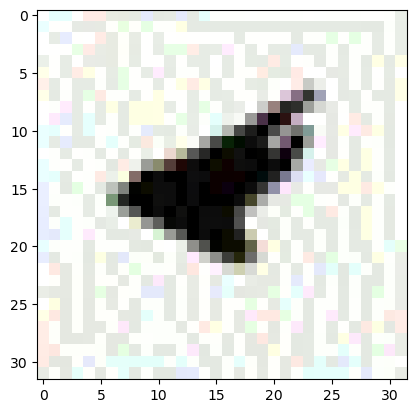

predicted :  bird
Label :  plane
2
0


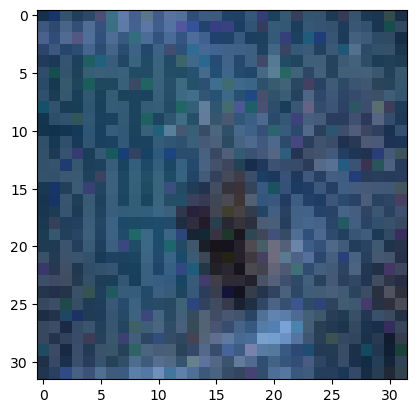

predicted :  deer
Label :  deer
4
4


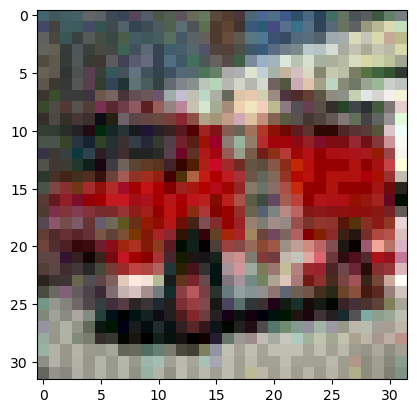

predicted :  truck
Label :  truck
9
9


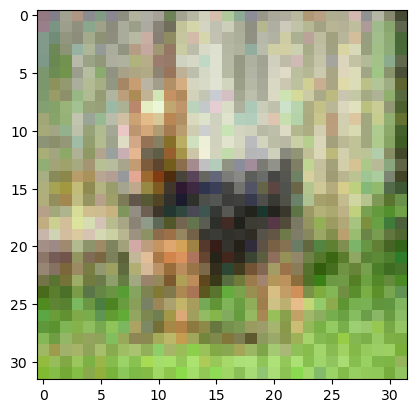

predicted :  deer
Label :  dog
4
5


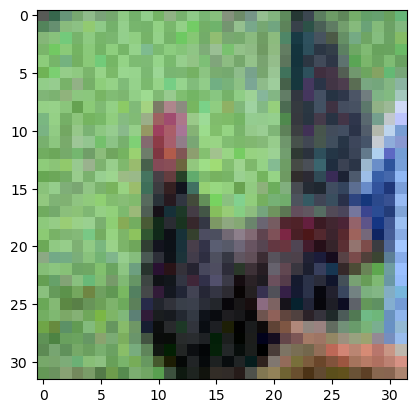

predicted :  bird
Label :  bird
2
2


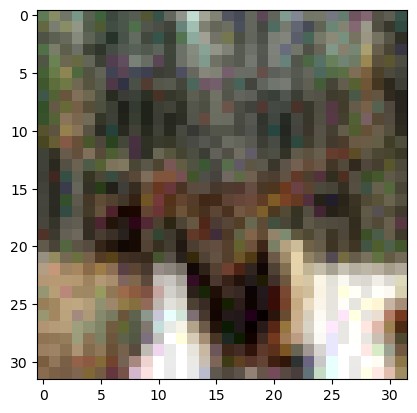

predicted :  deer
Label :  deer
4
4


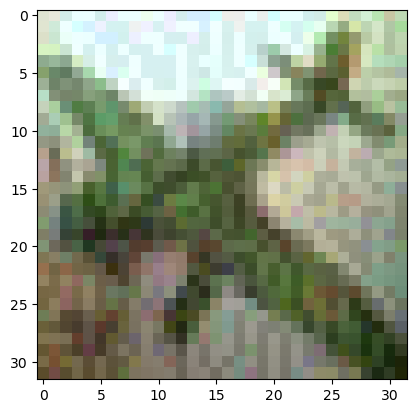

predicted :  plane
Label :  plane
0
0


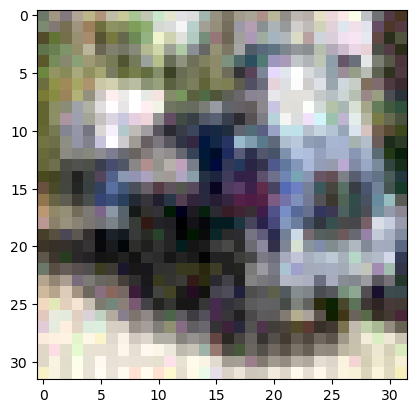

predicted :  truck
Label :  truck
9
9


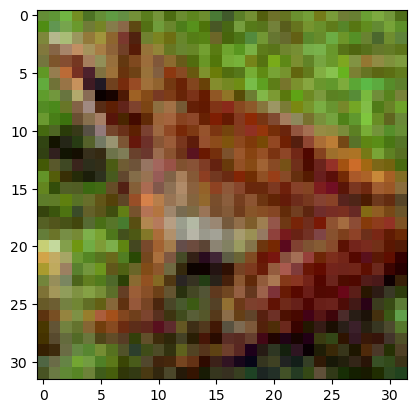

predicted :  frog
Label :  frog
6
6


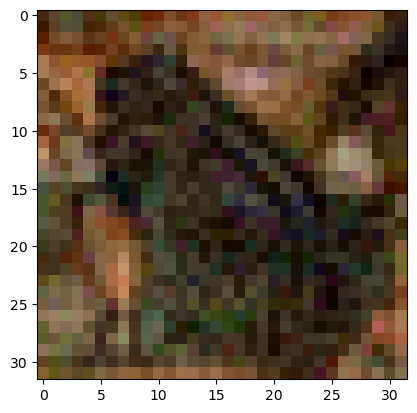

predicted :  frog
Label :  frog
6
6


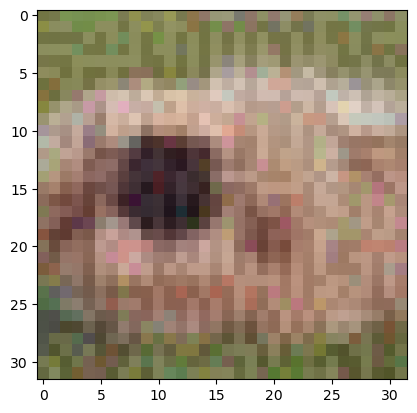

predicted :  dog
Label :  dog
5
5


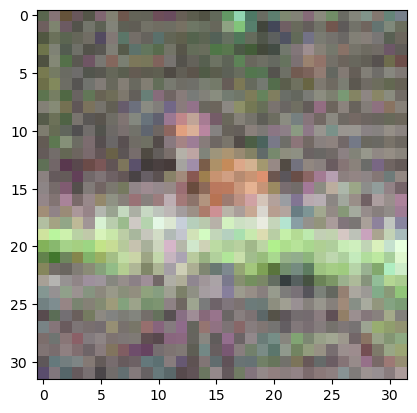

predicted :  bird
Label :  deer
2
4


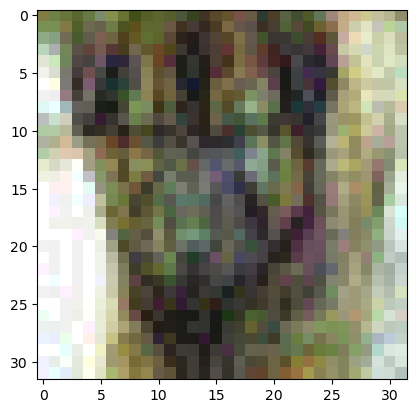

predicted :  cat
Label :  dog
3
5


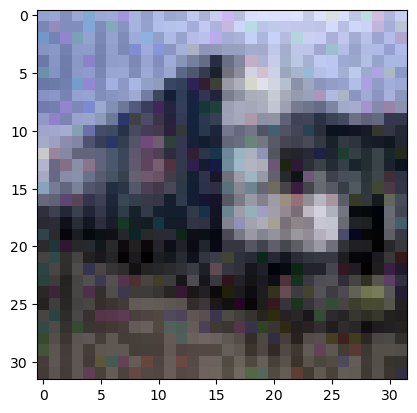

predicted :  truck
Label :  truck
9
9


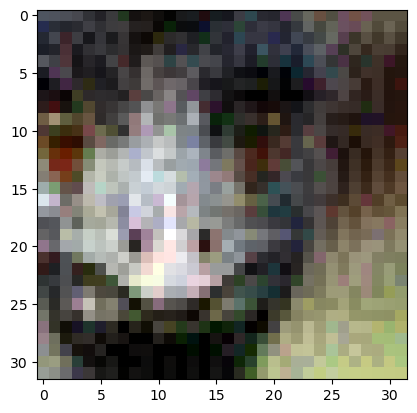

predicted :  cat
Label :  bird
3
2


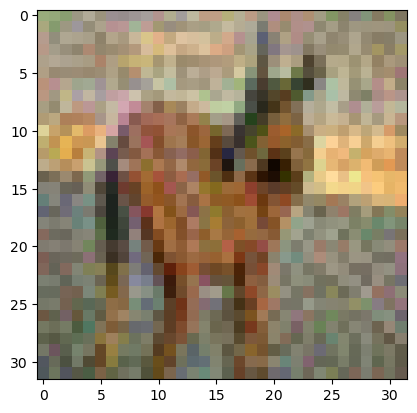

predicted :  deer
Label :  deer
4
4


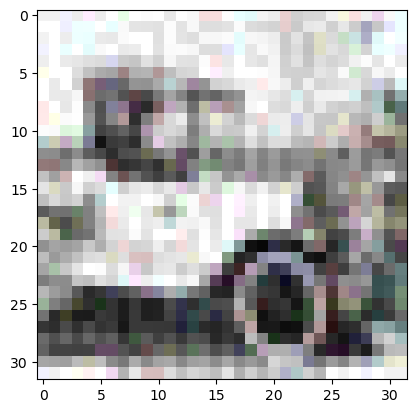

predicted :  car
Label :  car
1
1


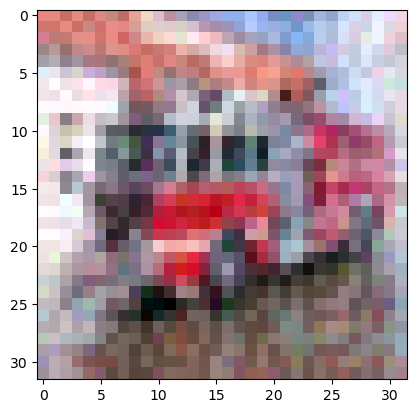

predicted :  truck
Label :  truck
9
9


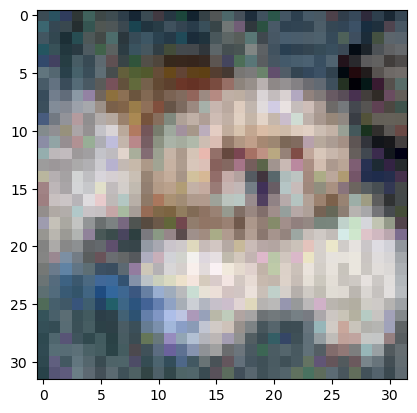

predicted :  dog
Label :  dog
5
5


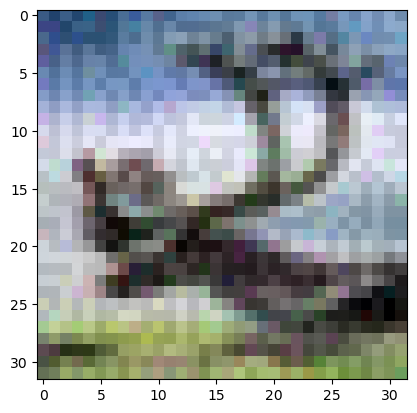

predicted :  deer
Label :  deer
4
4


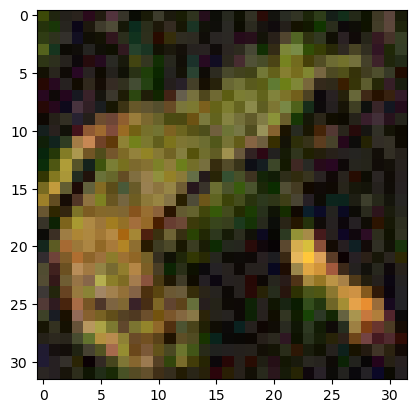

predicted :  frog
Label :  frog
6
6


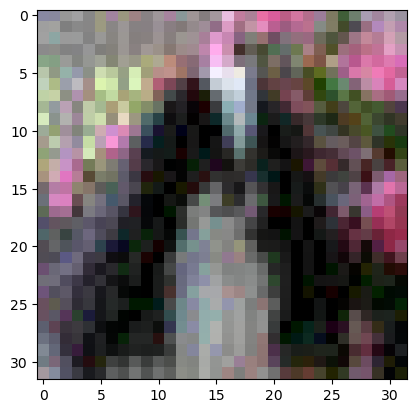

predicted :  horse
Label :  dog
7
5


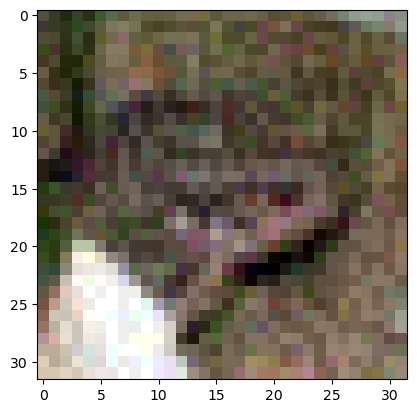

predicted :  frog
Label :  frog
6
6


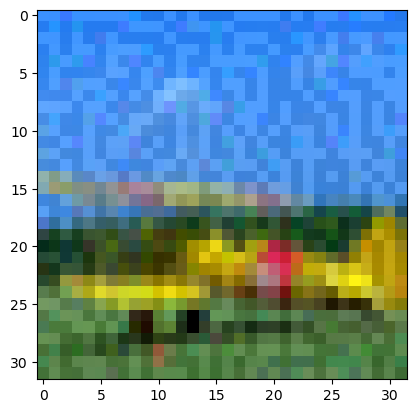

predicted :  plane
Label :  plane
0
0


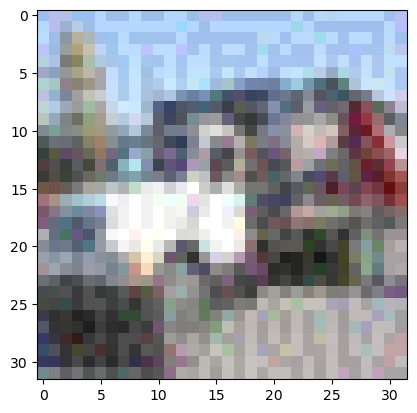

predicted :  truck
Label :  truck
9
9


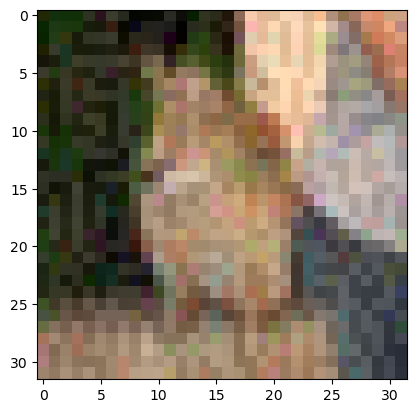

predicted :  cat
Label :  cat
3
3


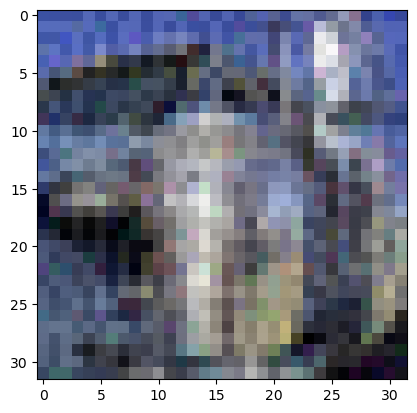

predicted :  truck
Label :  truck
9
9


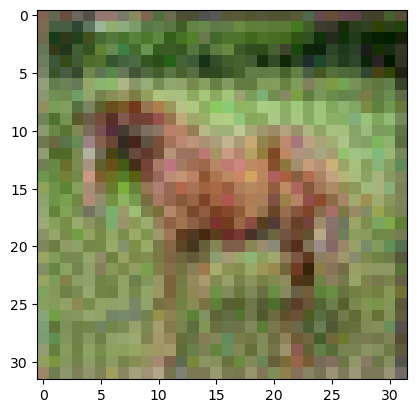

predicted :  horse
Label :  horse
7
7


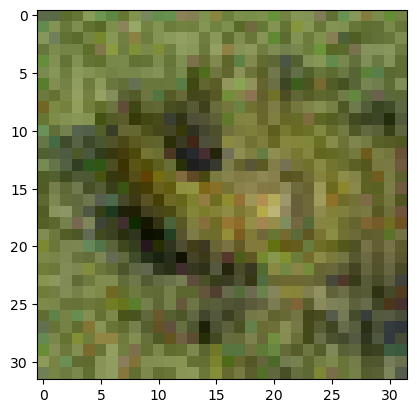

predicted :  deer
Label :  frog
4
6


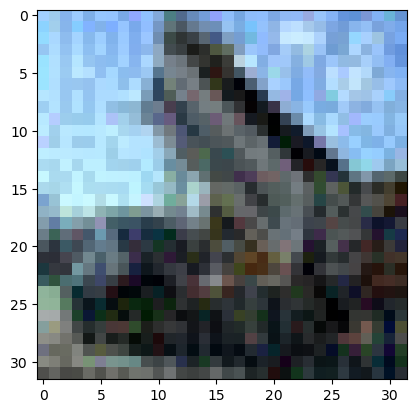

predicted :  truck
Label :  truck
9
9


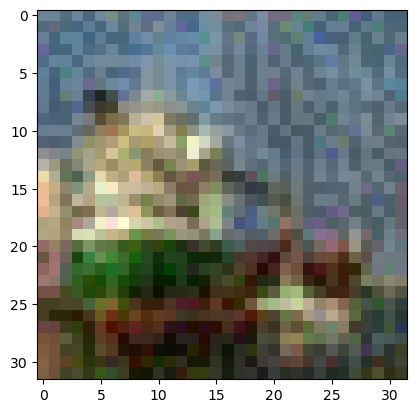

predicted :  ship
Label :  ship
8
8


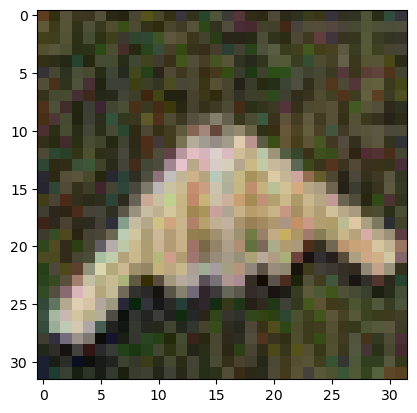

predicted :  horse
Label :  plane
7
0


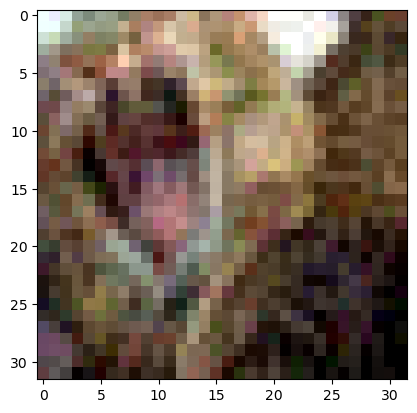

predicted :  cat
Label :  cat
3
3


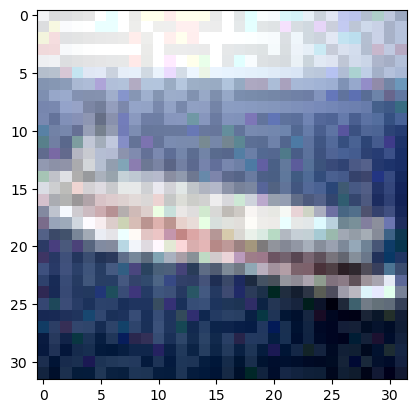

predicted :  ship
Label :  ship
8
8


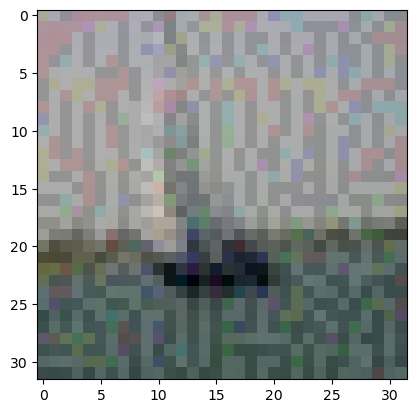

predicted :  ship
Label :  ship
8
8


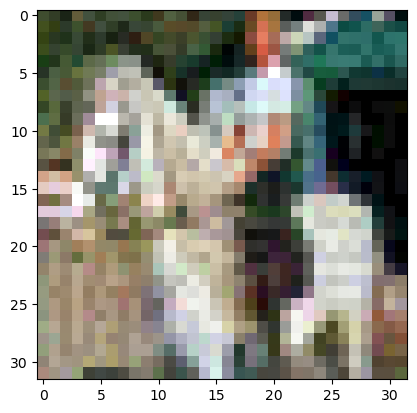

predicted :  horse
Label :  horse
7
7


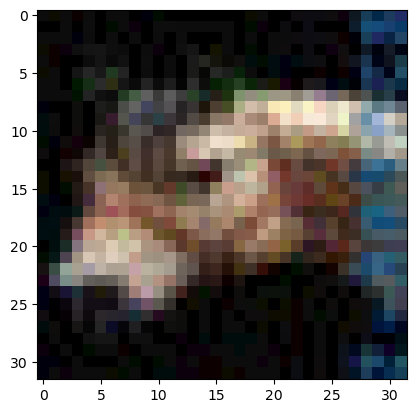

predicted :  cat
Label :  horse
3
7


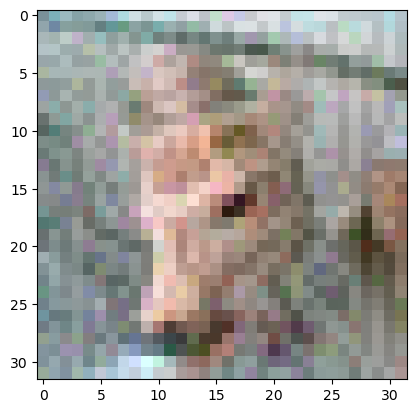

predicted :  cat
Label :  deer
3
4


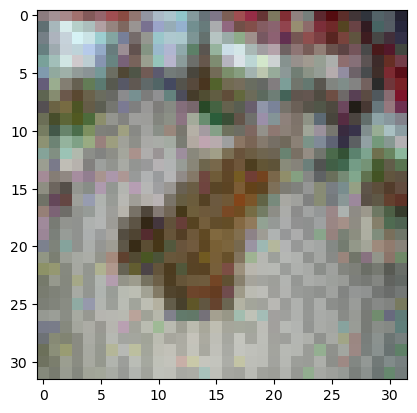

predicted :  cat
Label :  frog
3
6


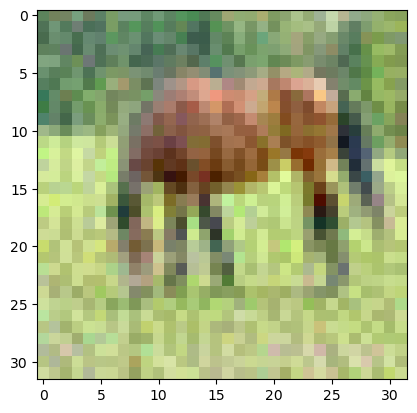

predicted :  horse
Label :  horse
7
7


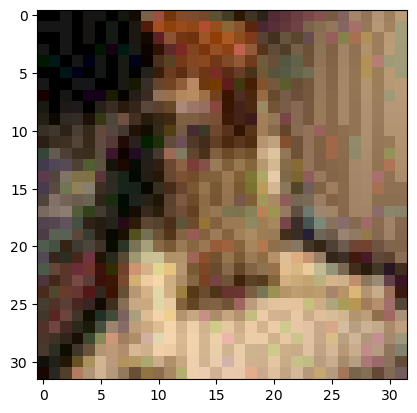

predicted :  dog
Label :  cat
5
3


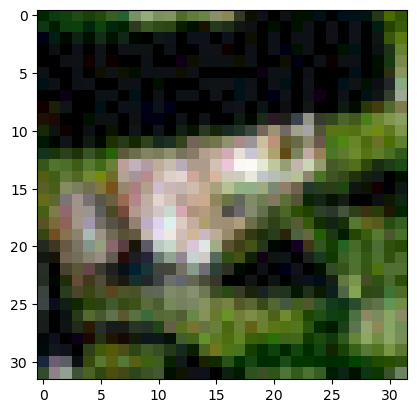

predicted :  frog
Label :  frog
6
6


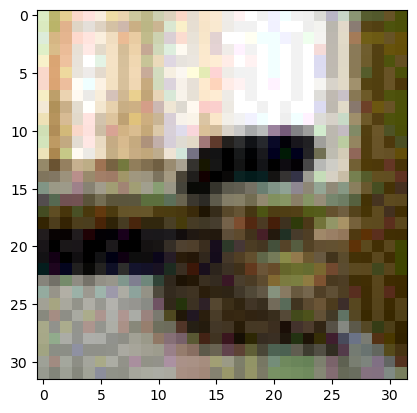

predicted :  cat
Label :  cat
3
3


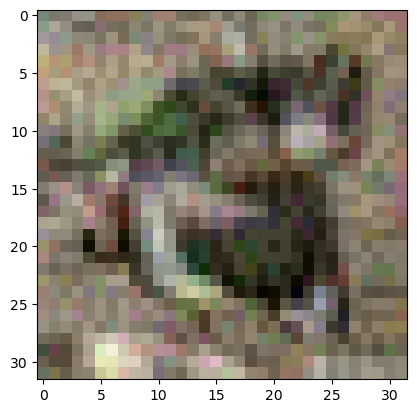

predicted :  frog
Label :  frog
6
6


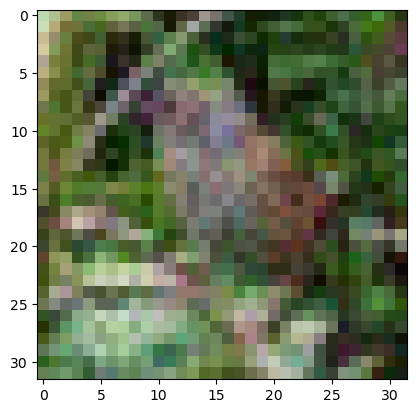

predicted :  bird
Label :  bird
2
2


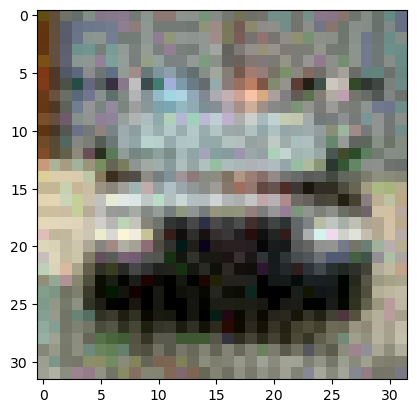

predicted :  car
Label :  car
1
1


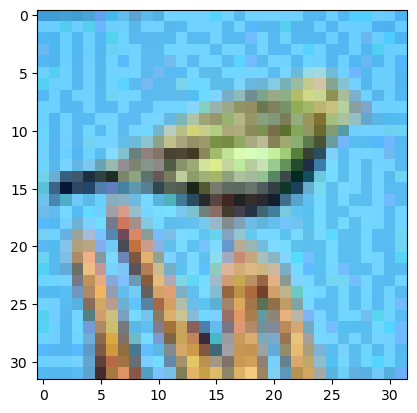

predicted :  bird
Label :  bird
2
2


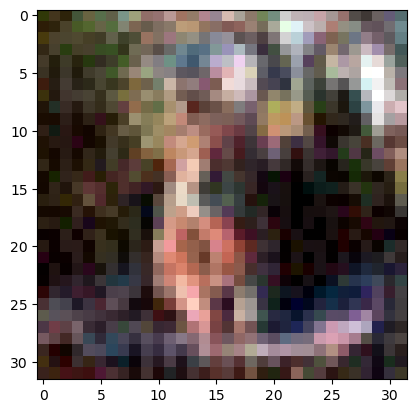

predicted :  cat
Label :  cat
3
3


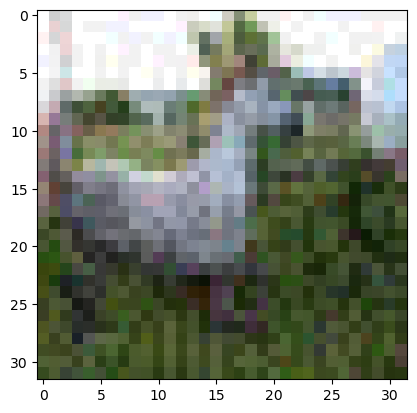

predicted :  deer
Label :  horse
4
7


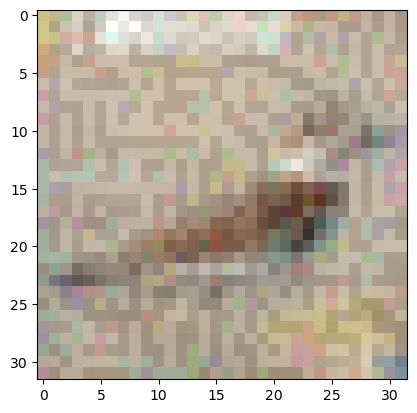

predicted :  bird
Label :  bird
2
2


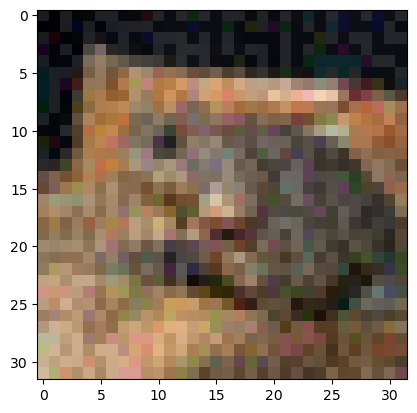

predicted :  frog
Label :  frog
6
6


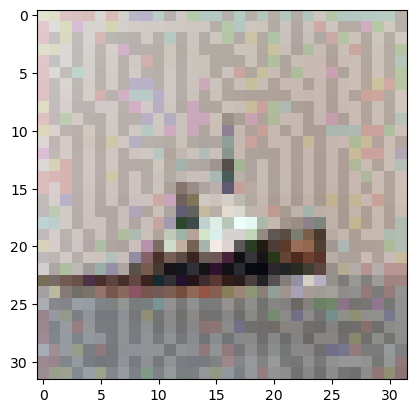

predicted :  ship
Label :  ship
8
8


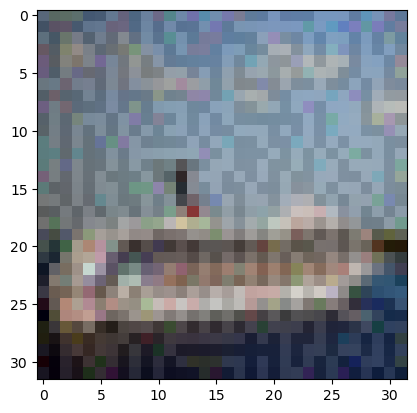

predicted :  ship
Label :  ship
8
8


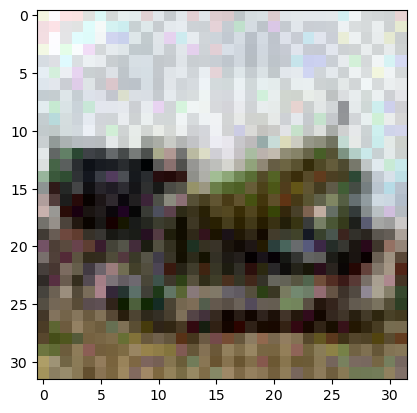

predicted :  plane
Label :  plane
0
0


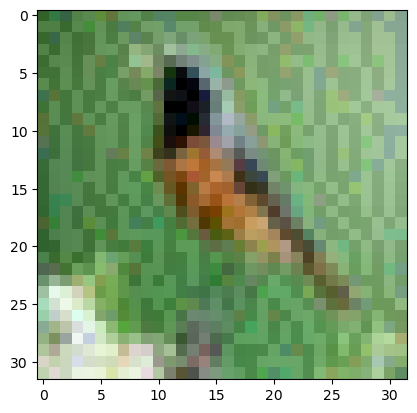

predicted :  bird
Label :  bird
2
2


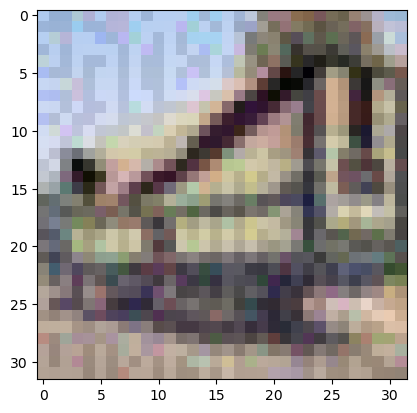

predicted :  plane
Label :  truck
0
9


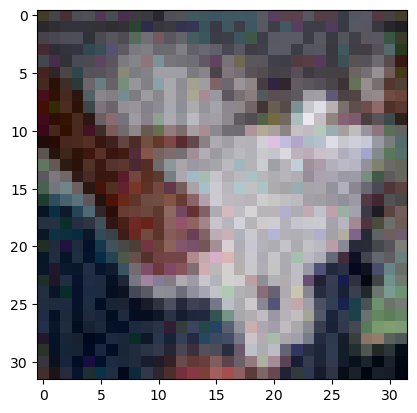

predicted :  cat
Label :  cat
3
3


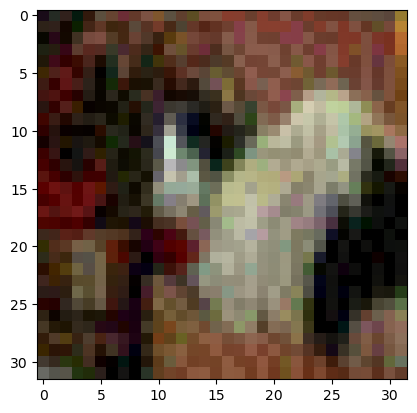

predicted :  dog
Label :  cat
5
3


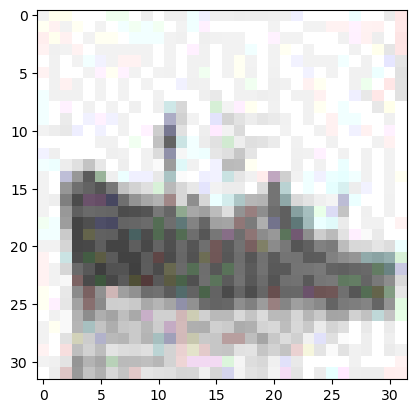

predicted :  ship
Label :  ship
8
8


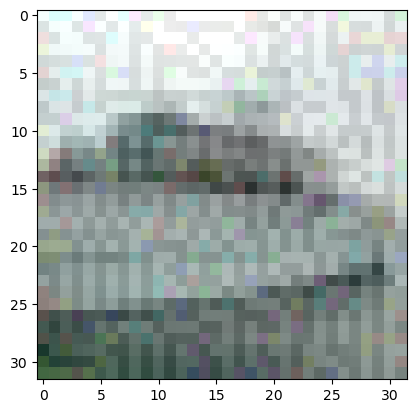

predicted :  ship
Label :  ship
8
8


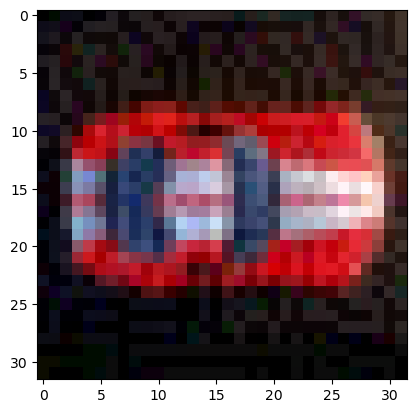

predicted :  car
Label :  car
1
1


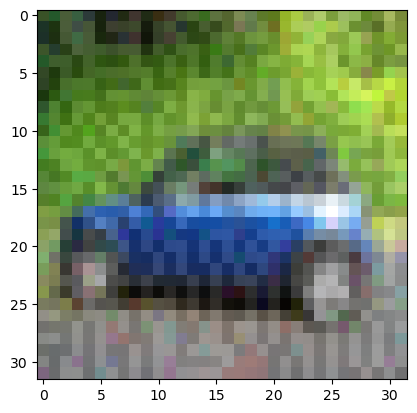

predicted :  car
Label :  car
1
1


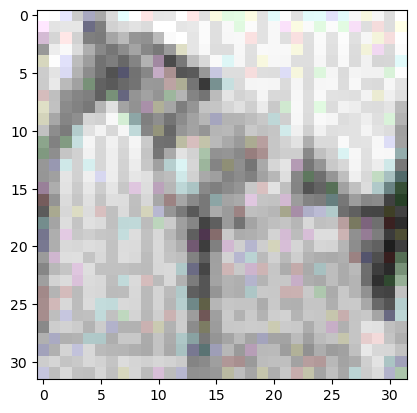

predicted :  horse
Label :  horse
7
7


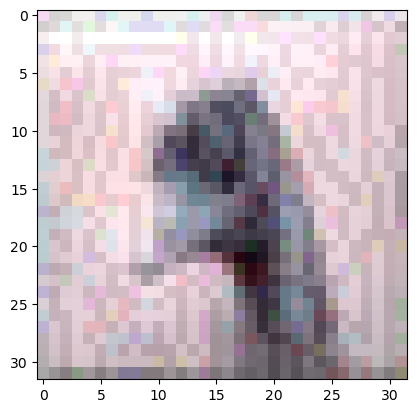

predicted :  bird
Label :  bird
2
2


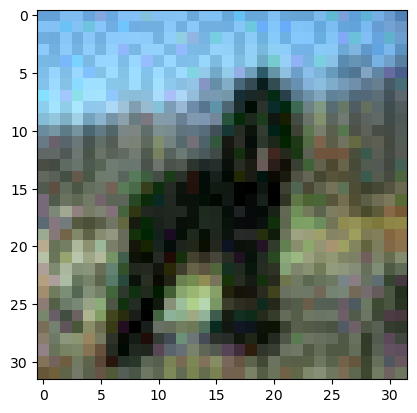

predicted :  dog
Label :  dog
5
5


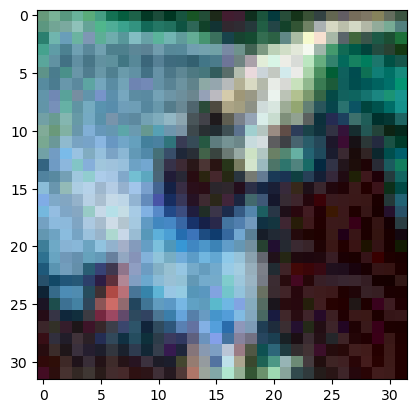

predicted :  bird
Label :  bird
2
2


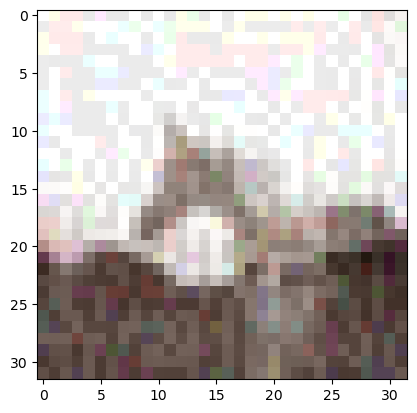

predicted :  deer
Label :  horse
4
7


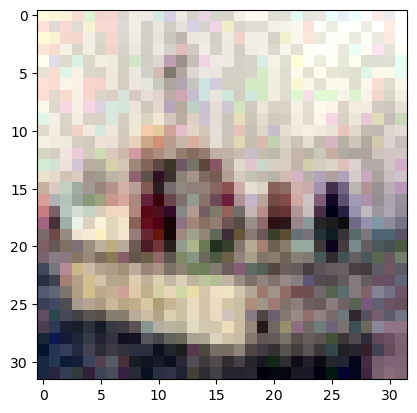

predicted :  ship
Label :  ship
8
8


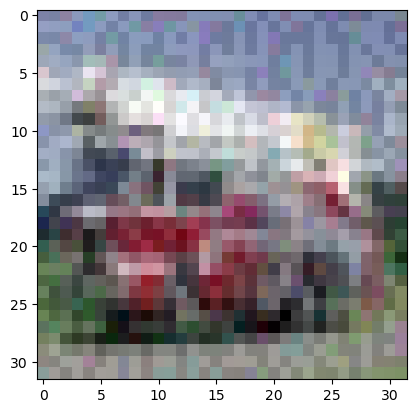

predicted :  truck
Label :  truck
9
9


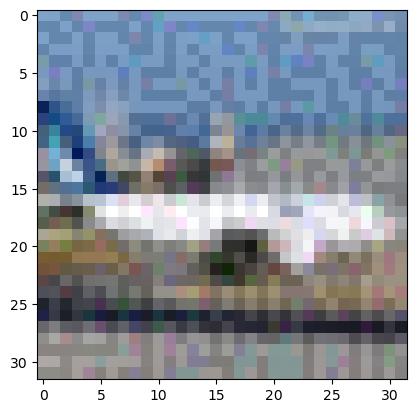

predicted :  plane
Label :  plane
0
0


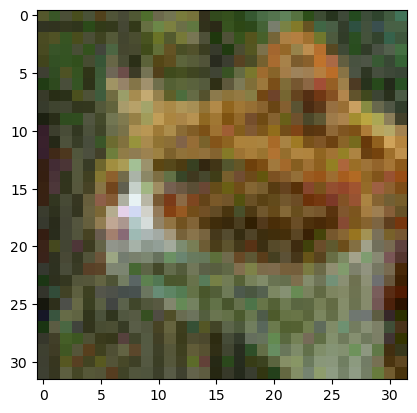

predicted :  cat
Label :  cat
3
3


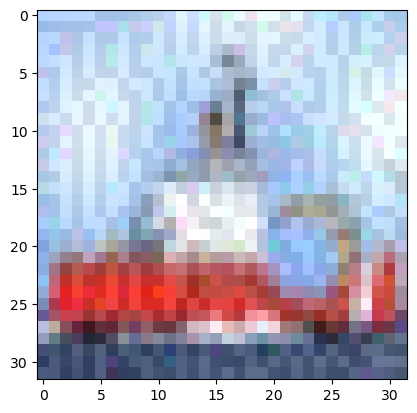

predicted :  ship
Label :  ship
8
8


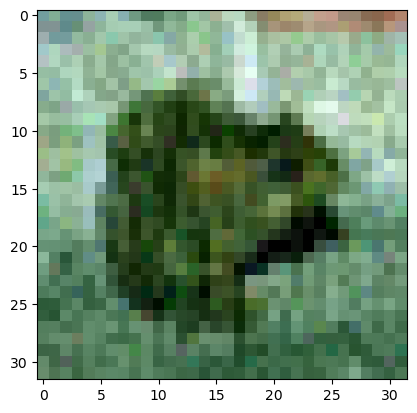

predicted :  frog
Label :  frog
6
6


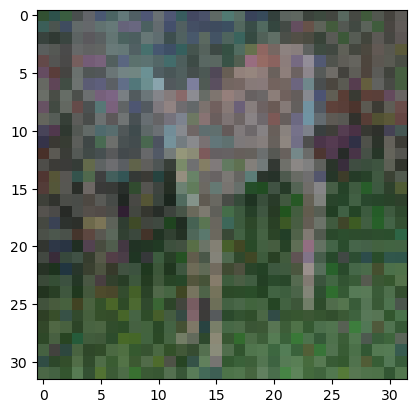

predicted :  deer
Label :  deer
4
4


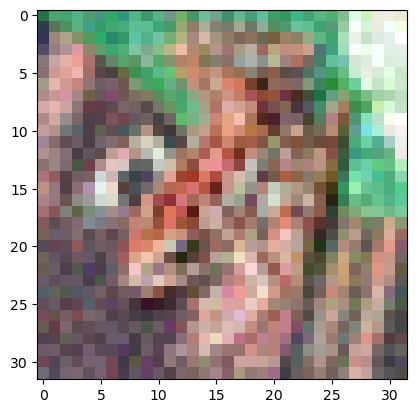

predicted :  frog
Label :  frog
6
6


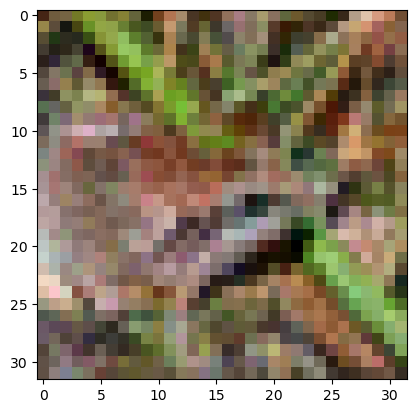

predicted :  frog
Label :  frog
6
6


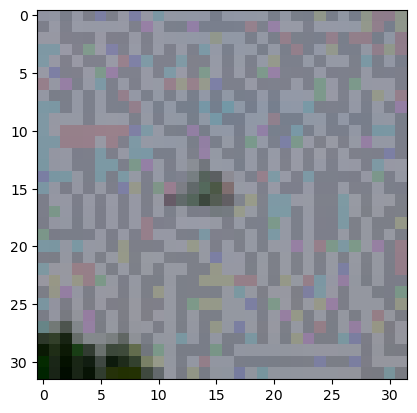

predicted :  plane
Label :  plane
0
0


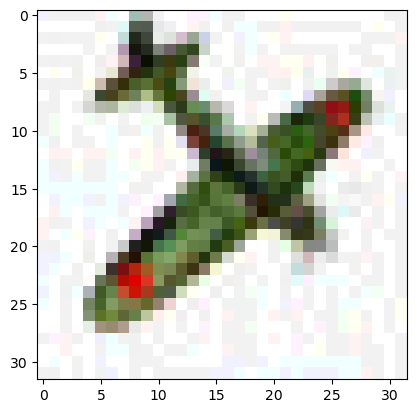

predicted :  plane
Label :  plane
0
0


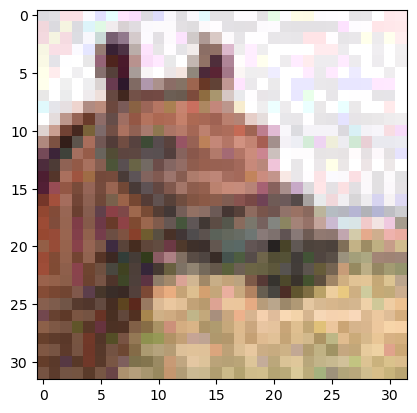

predicted :  horse
Label :  horse
7
7


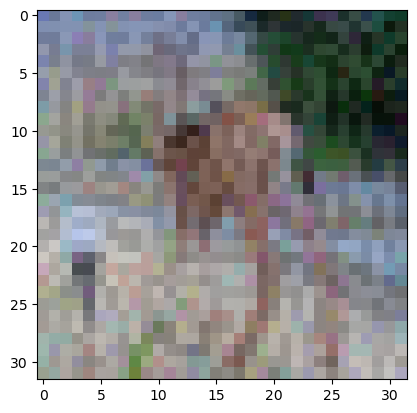

predicted :  deer
Label :  deer
4
4


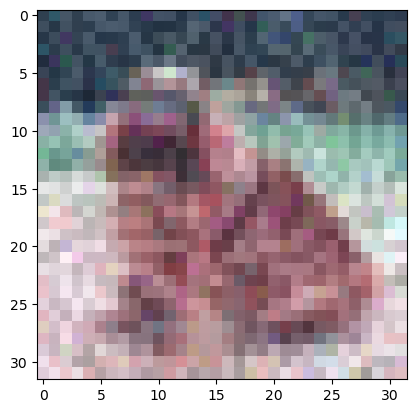

predicted :  dog
Label :  dog
5
5


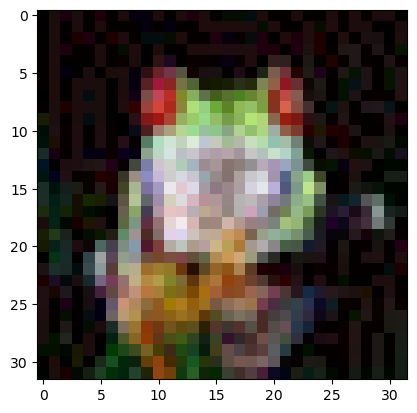

predicted :  frog
Label :  frog
6
6


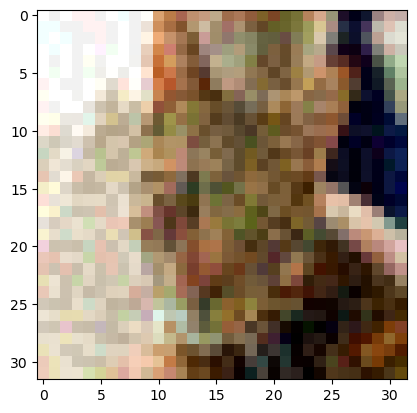

predicted :  cat
Label :  cat
3
3


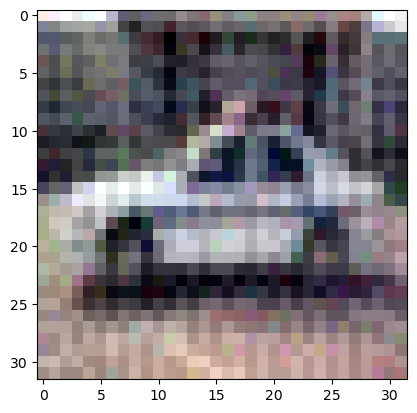

predicted :  car
Label :  car
1
1


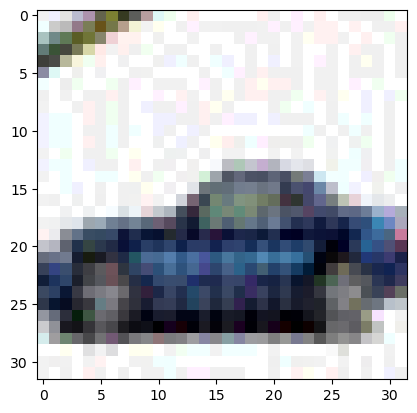

predicted :  car
Label :  car
1
1


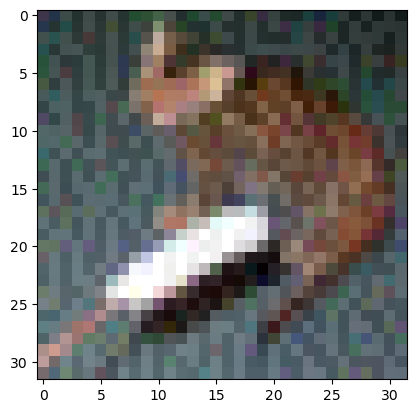

predicted :  frog
Label :  cat
6
3


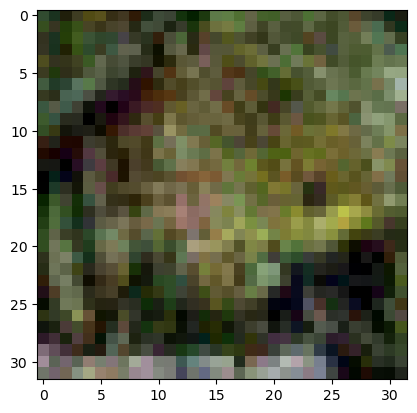

predicted :  frog
Label :  frog
6
6


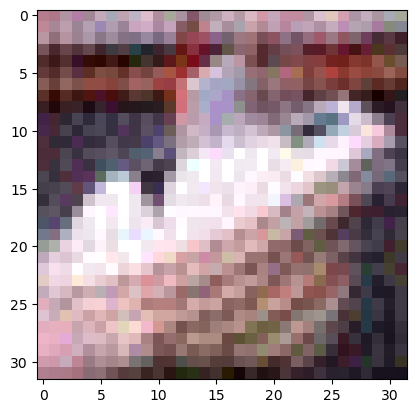

predicted :  ship
Label :  ship
8
8


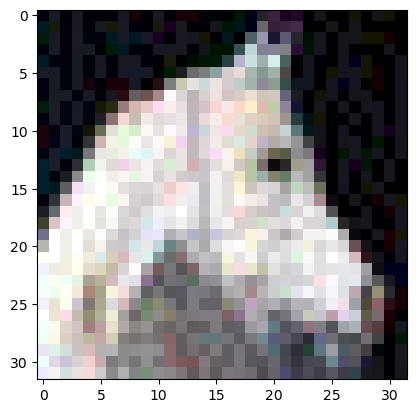

predicted :  horse
Label :  horse
7
7


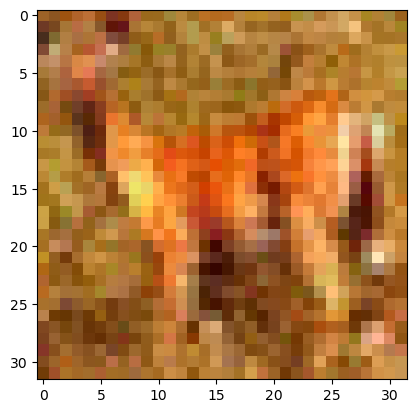

predicted :  deer
Label :  deer
4
4


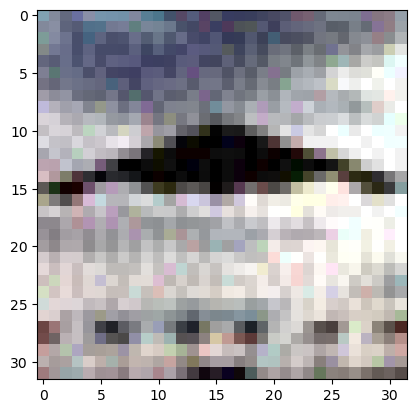

predicted :  plane
Label :  plane
0
0


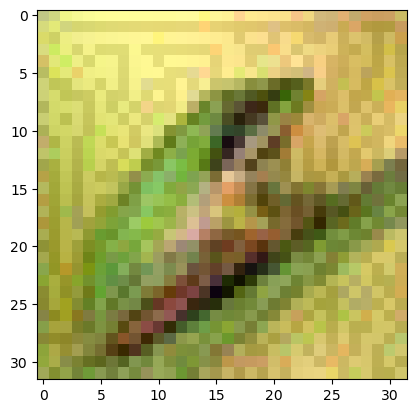

predicted :  frog
Label :  frog
6
6


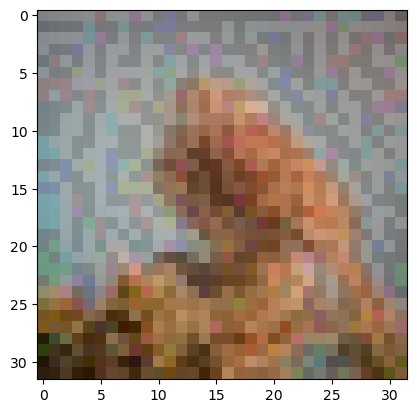

predicted :  bird
Label :  bird
2
2


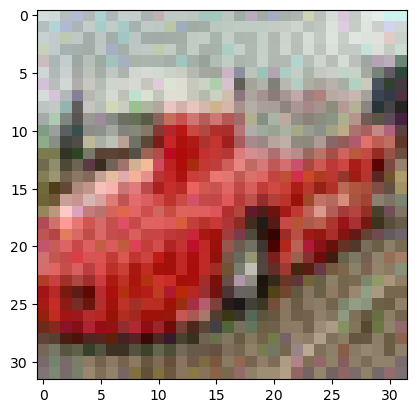

predicted :  car
Label :  car
1
1


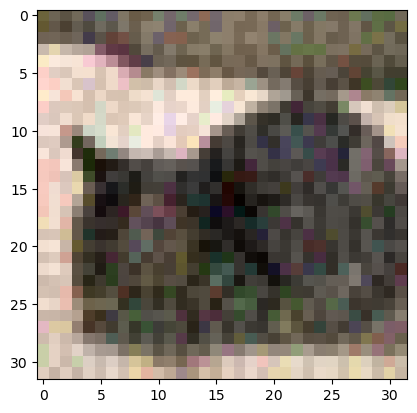

predicted :  cat
Label :  cat
3
3


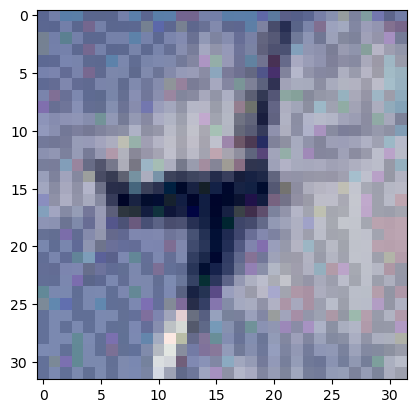

predicted :  plane
Label :  plane
0
0


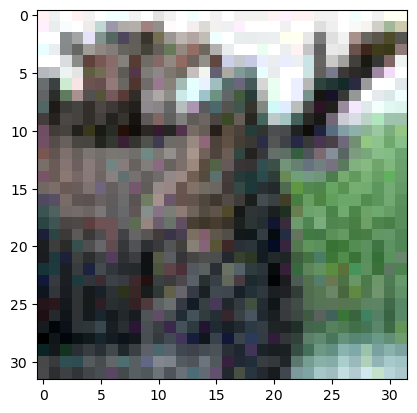

predicted :  deer
Label :  deer
4
4


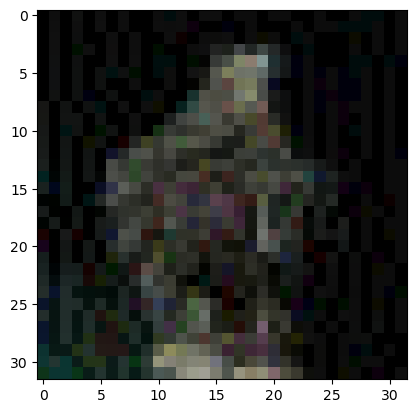

predicted :  bird
Label :  bird
2
2


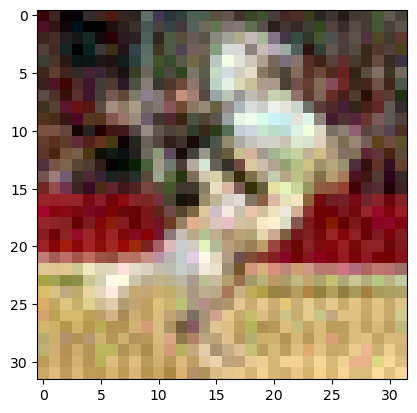

predicted :  horse
Label :  horse
7
7


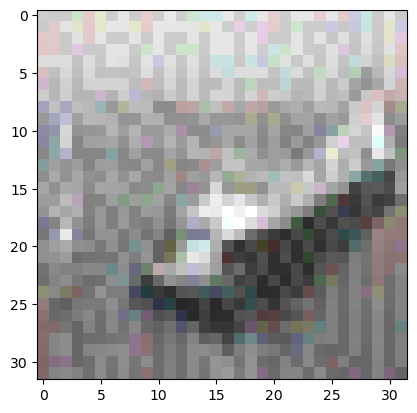

predicted :  ship
Label :  ship
8
8


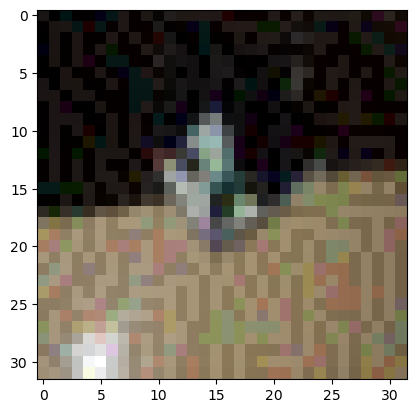

predicted :  cat
Label :  cat
3
3


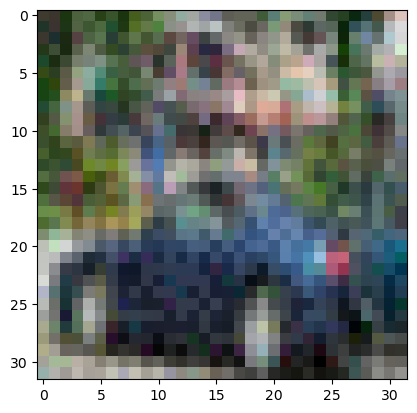

predicted :  car
Label :  car
1
1


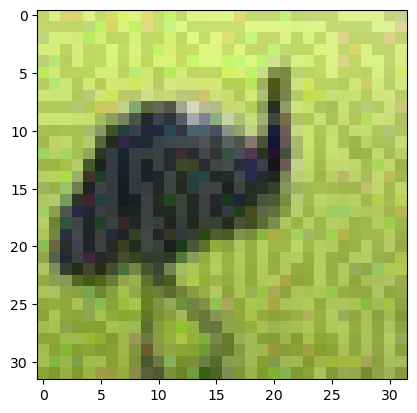

predicted :  bird
Label :  bird
2
2


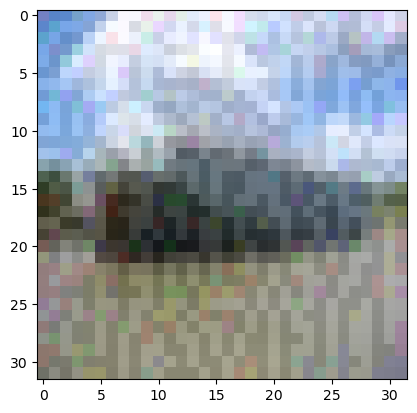

predicted :  ship
Label :  ship
8
8


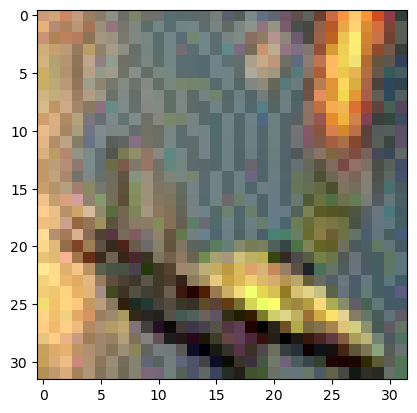

predicted :  plane
Label :  plane
0
0


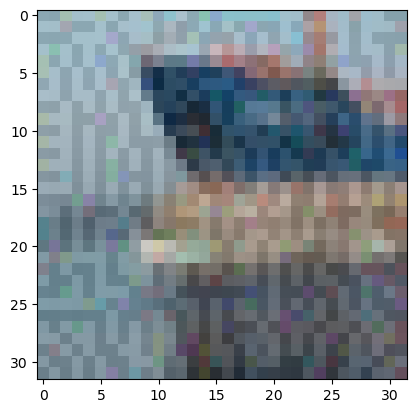

predicted :  bird
Label :  ship
2
8


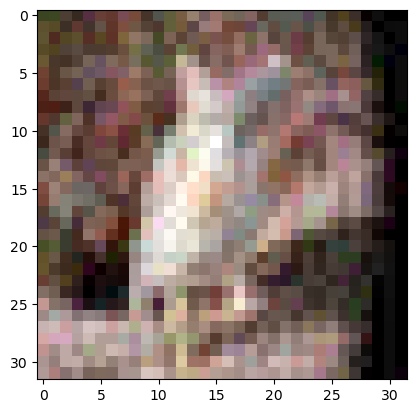

predicted :  cat
Label :  cat
3
3


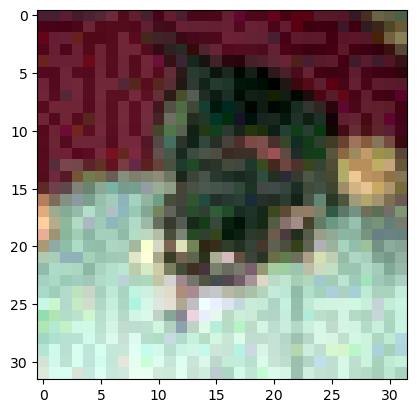

predicted :  cat
Label :  dog
3
5


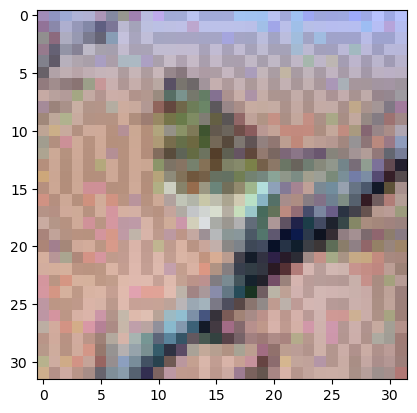

predicted :  bird
Label :  bird
2
2


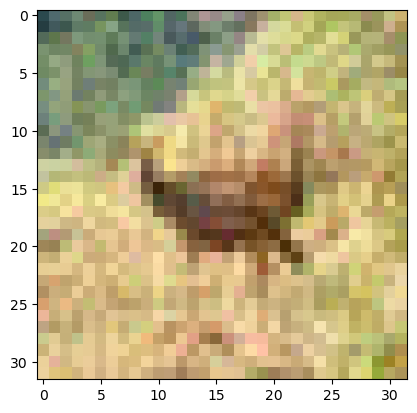

predicted :  deer
Label :  deer
4
4


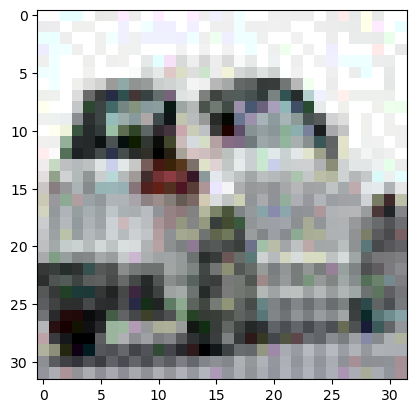

predicted :  car
Label :  car
1
1


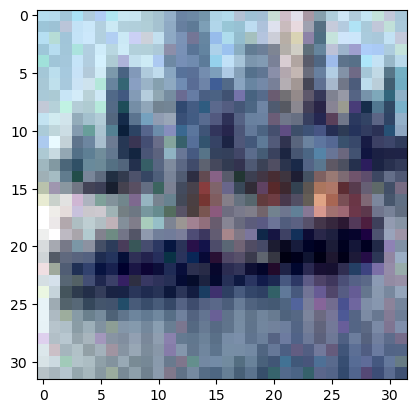

predicted :  ship
Label :  ship
8
8


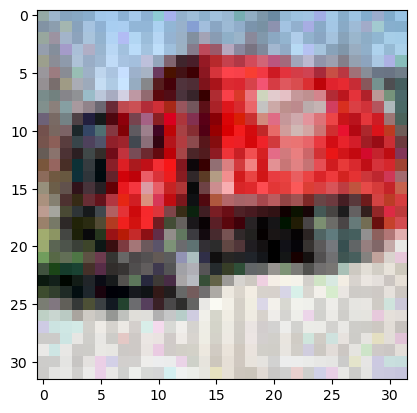

predicted :  truck
Label :  truck
9
9


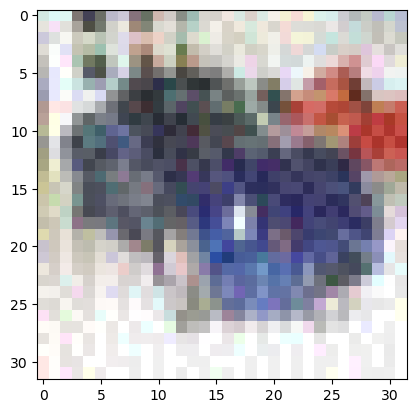

predicted :  car
Label :  car
1
1


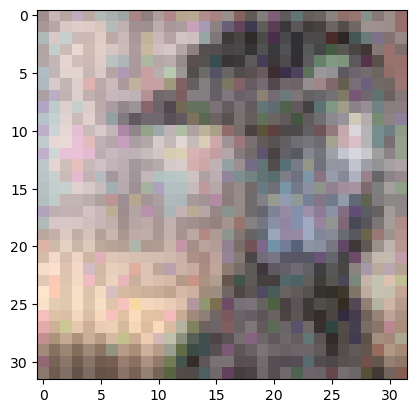

predicted :  bird
Label :  bird
2
2


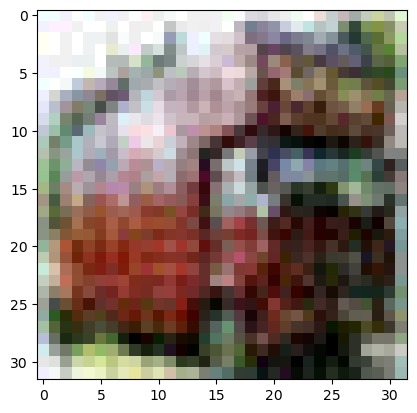

predicted :  truck
Label :  truck
9
9


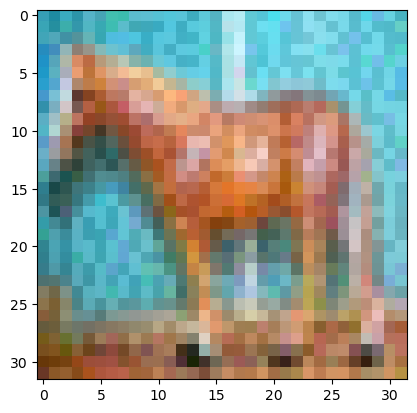

predicted :  horse
Label :  horse
7
7


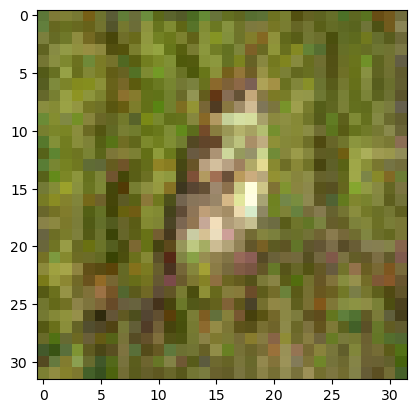

predicted :  cat
Label :  bird
3
2


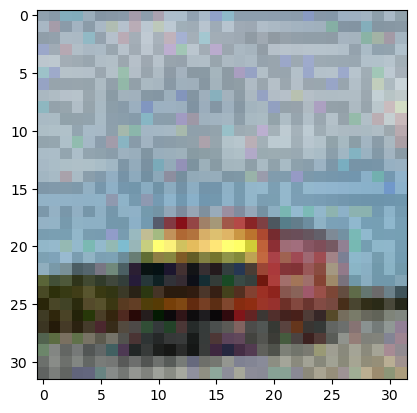

predicted :  car
Label :  truck
1
9


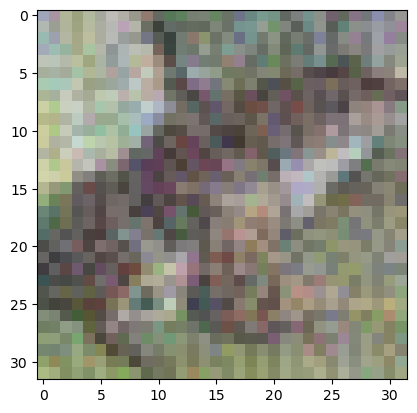

predicted :  frog
Label :  frog
6
6


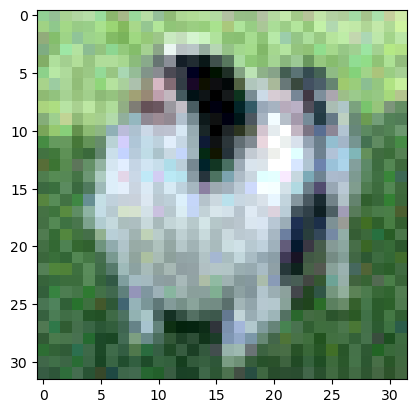

predicted :  dog
Label :  dog
5
5


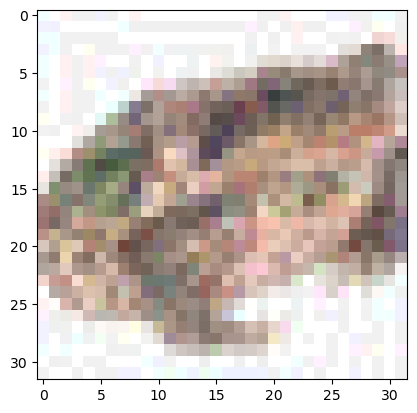

predicted :  frog
Label :  frog
6
6


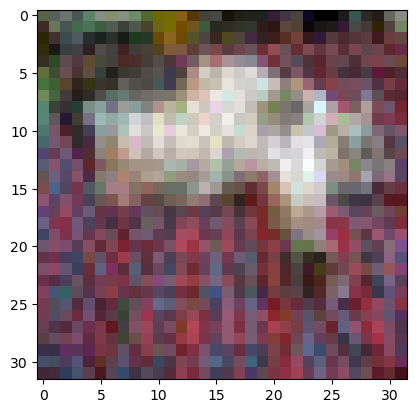

predicted :  cat
Label :  cat
3
3


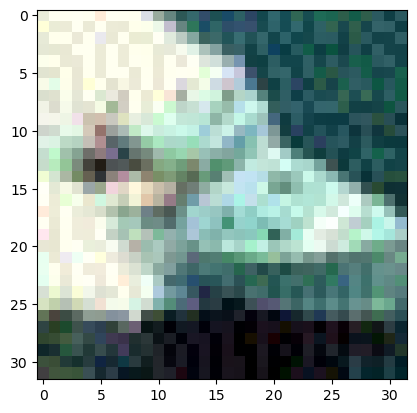

predicted :  ship
Label :  ship
8
8


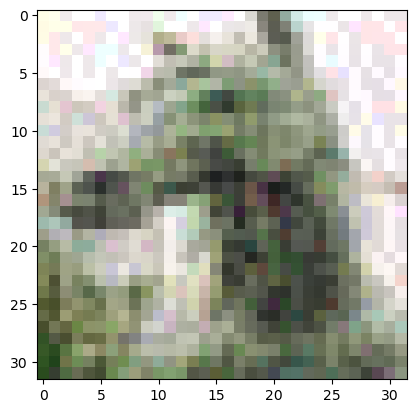

predicted :  horse
Label :  horse
7
7


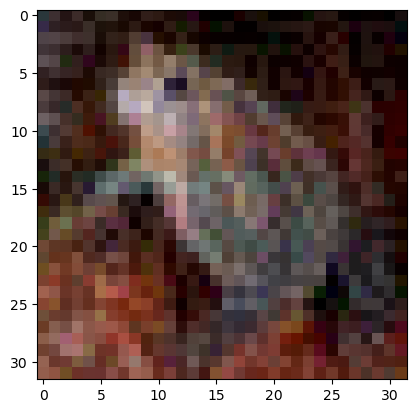

predicted :  frog
Label :  frog
6
6


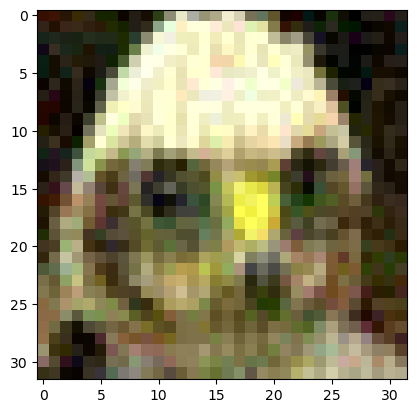

predicted :  frog
Label :  bird
6
2


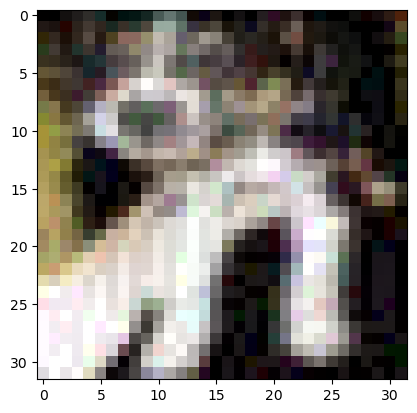

predicted :  dog
Label :  dog
5
5


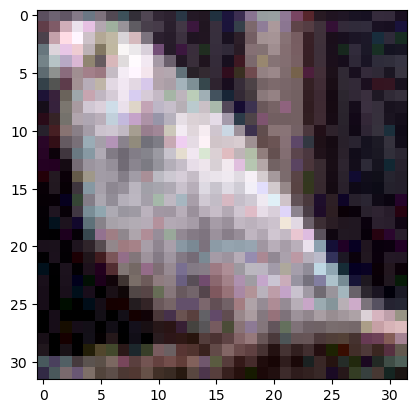

predicted :  bird
Label :  bird
2
2


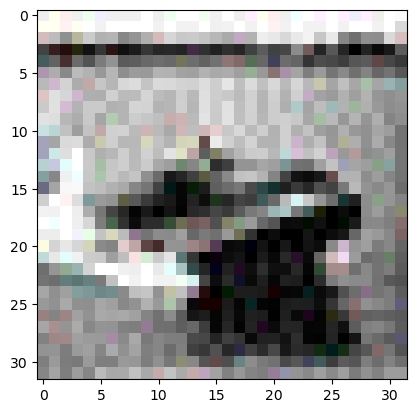

predicted :  plane
Label :  ship
0
8


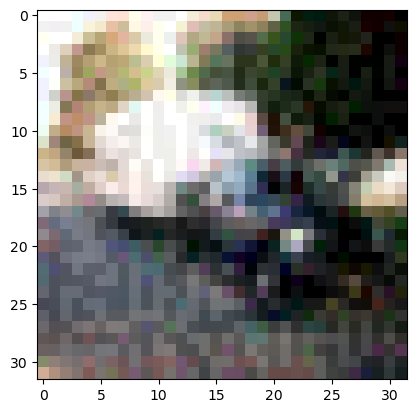

predicted :  car
Label :  truck
1
9


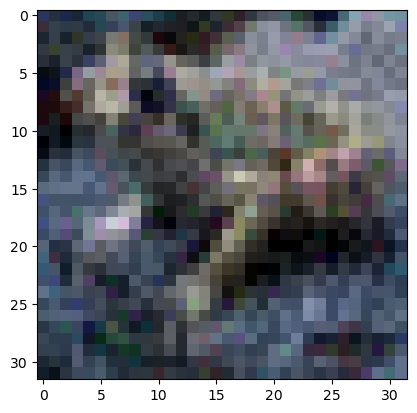

predicted :  frog
Label :  frog
6
6


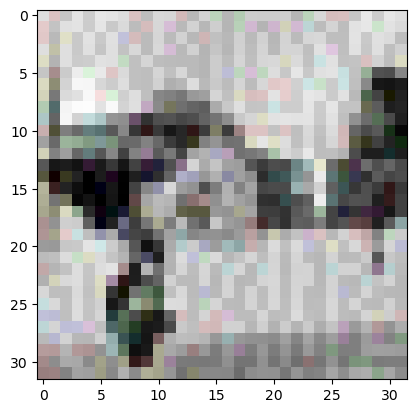

predicted :  plane
Label :  plane
0
0


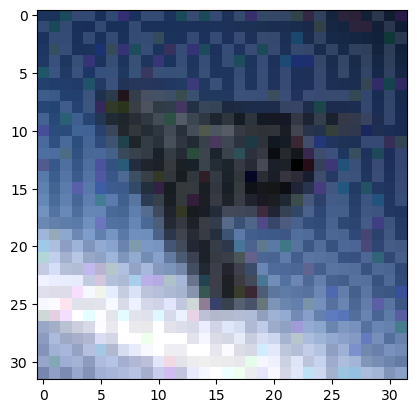

predicted :  plane
Label :  plane
0
0


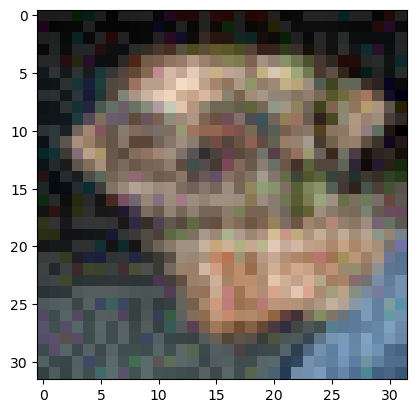

predicted :  dog
Label :  dog
5
5


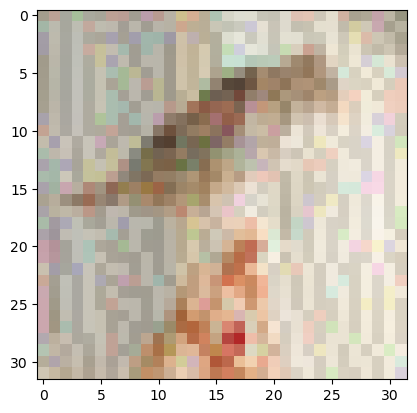

predicted :  bird
Label :  bird
2
2


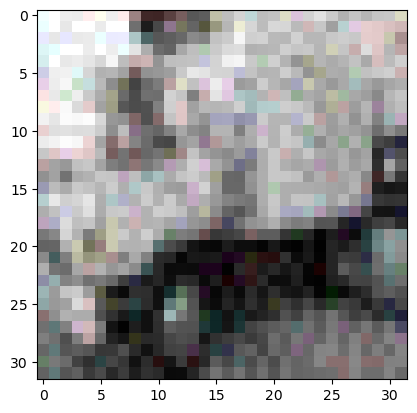

predicted :  truck
Label :  truck
9
9


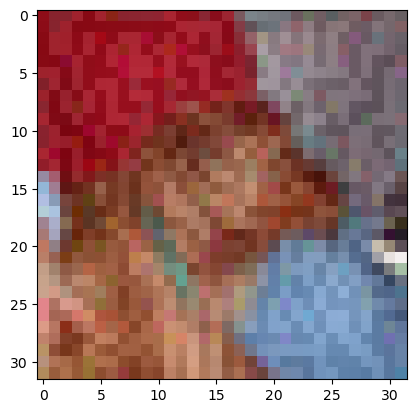

predicted :  cat
Label :  dog
3
5


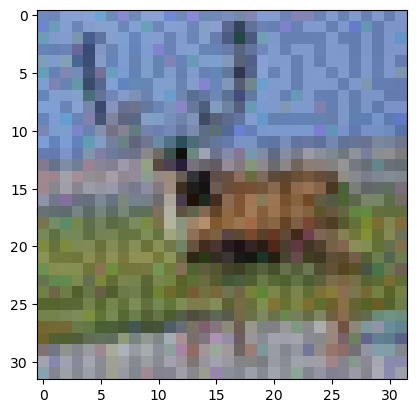

predicted :  deer
Label :  deer
4
4


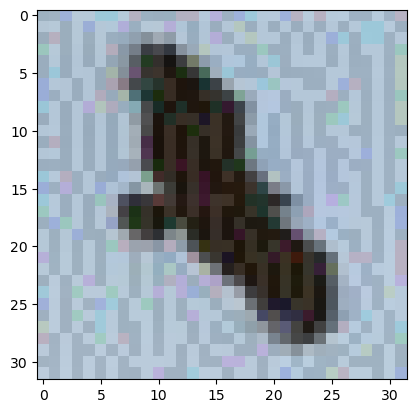

predicted :  bird
Label :  bird
2
2


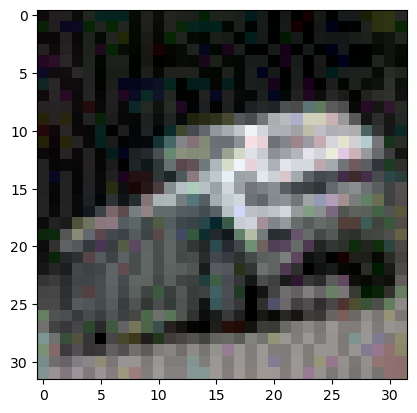

predicted :  car
Label :  car
1
1


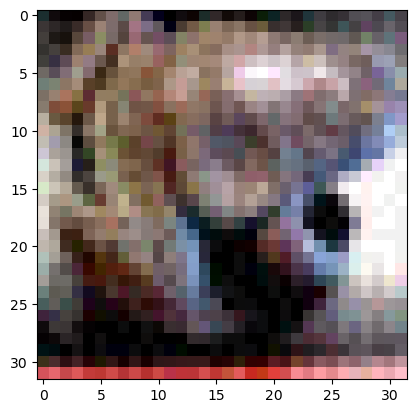

predicted :  frog
Label :  frog
6
6


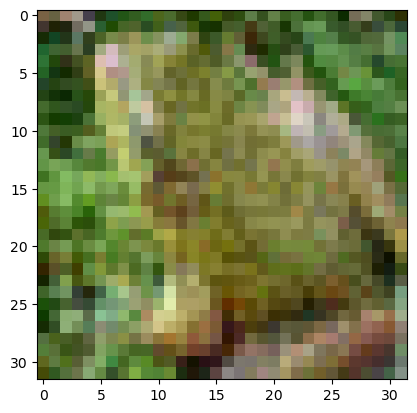

predicted :  frog
Label :  frog
6
6


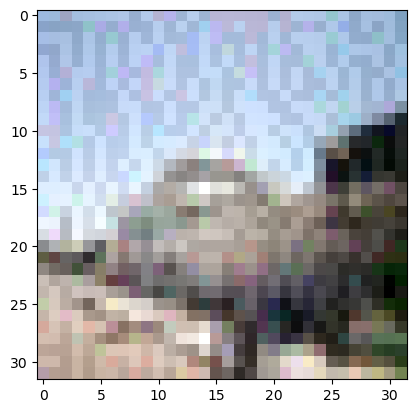

predicted :  plane
Label :  ship
0
8


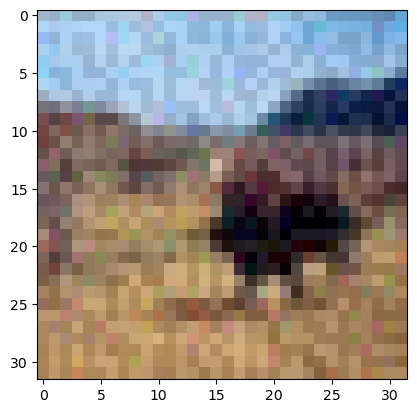

predicted :  bird
Label :  deer
2
4


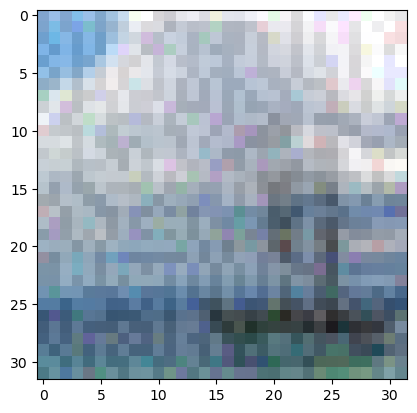

predicted :  ship
Label :  ship
8
8


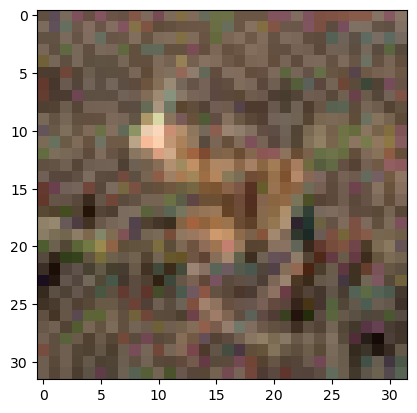

predicted :  deer
Label :  deer
4
4


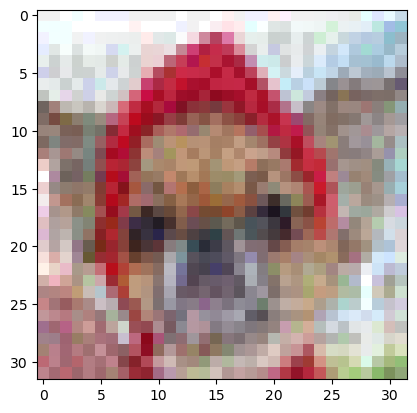

predicted :  dog
Label :  dog
5
5


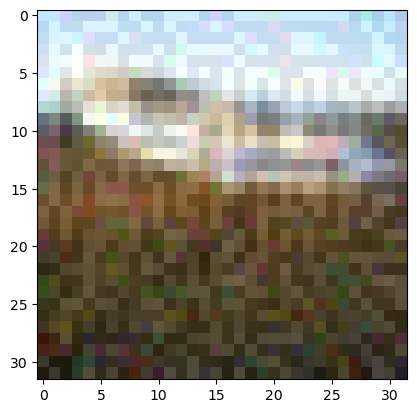

predicted :  plane
Label :  plane
0
0


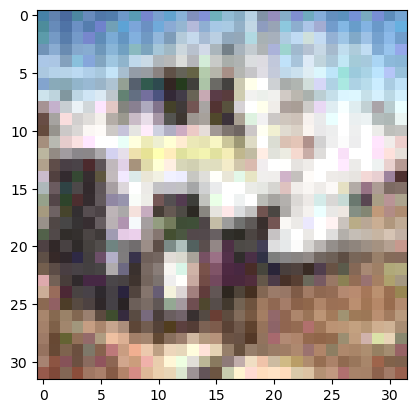

predicted :  truck
Label :  truck
9
9


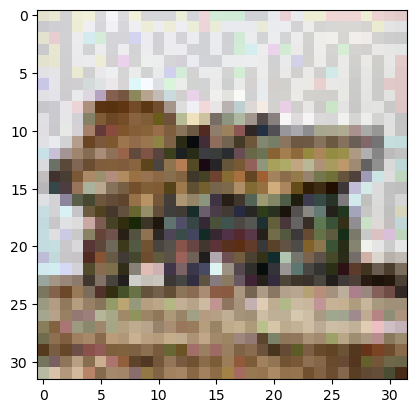

predicted :  plane
Label :  truck
0
9


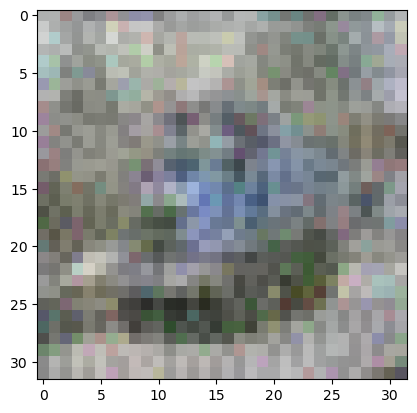

predicted :  truck
Label :  truck
9
9


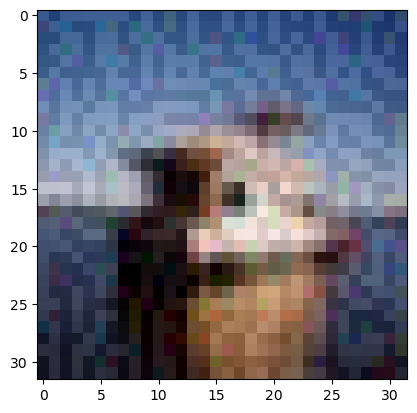

predicted :  ship
Label :  ship
8
8


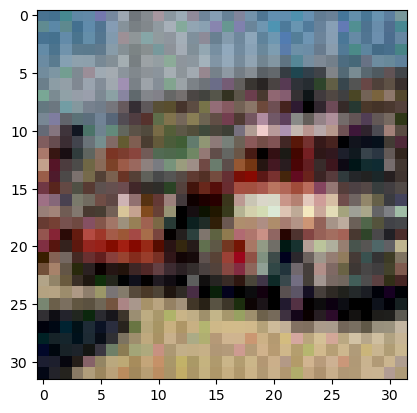

predicted :  truck
Label :  truck
9
9


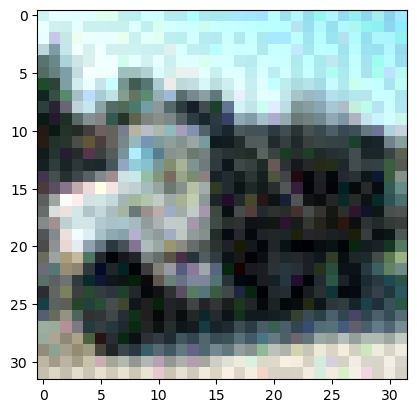

predicted :  truck
Label :  truck
9
9


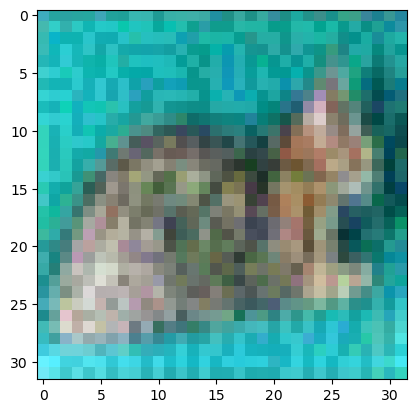

predicted :  cat
Label :  cat
3
3


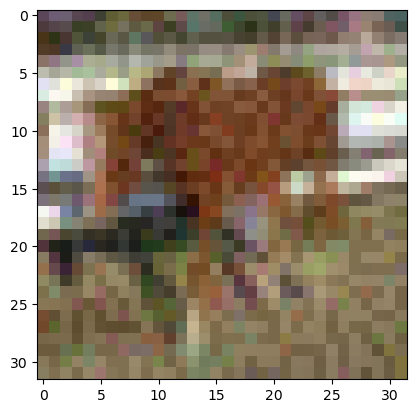

predicted :  horse
Label :  horse
7
7


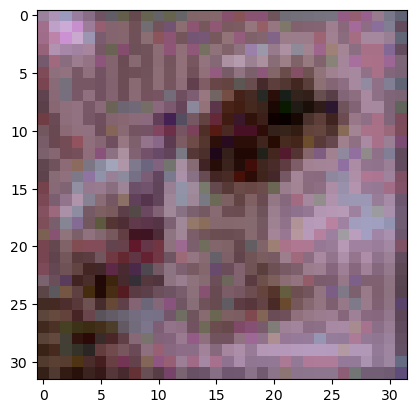

predicted :  bird
Label :  dog
2
5


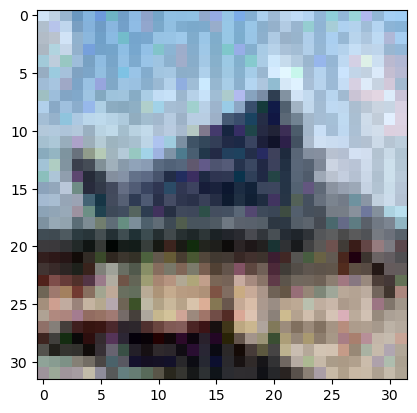

predicted :  plane
Label :  plane
0
0


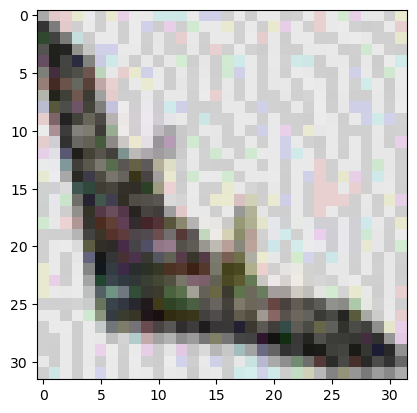

predicted :  plane
Label :  plane
0
0


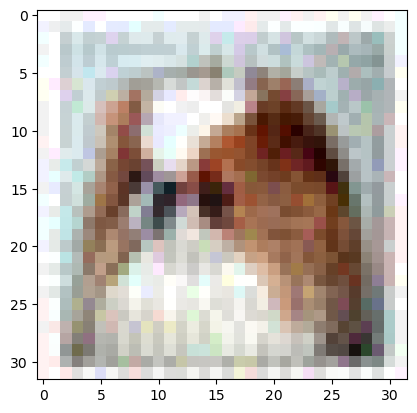

predicted :  dog
Label :  dog
5
5


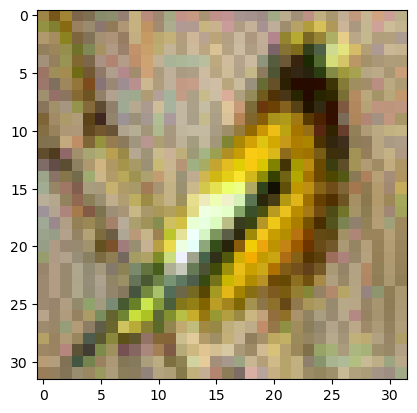

predicted :  bird
Label :  bird
2
2


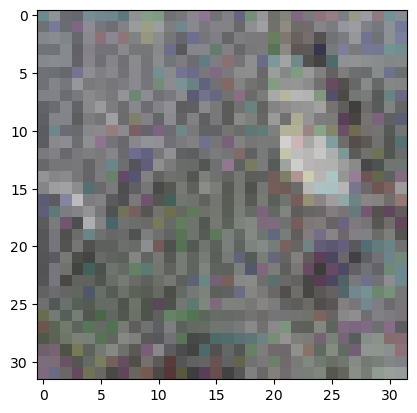

predicted :  bird
Label :  bird
2
2


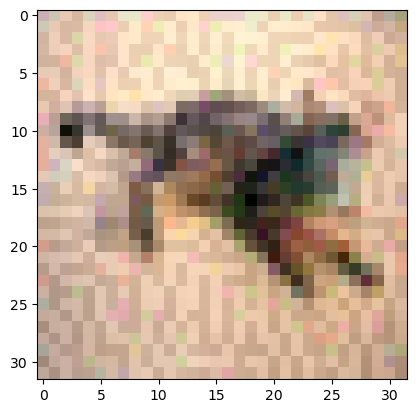

predicted :  cat
Label :  cat
3
3


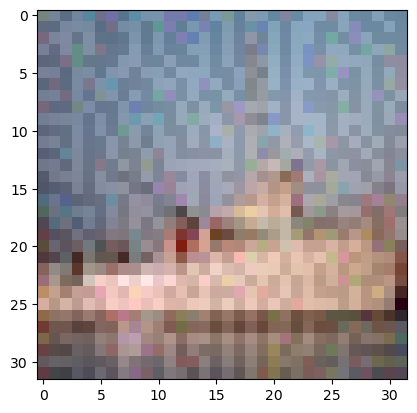

predicted :  ship
Label :  ship
8
8


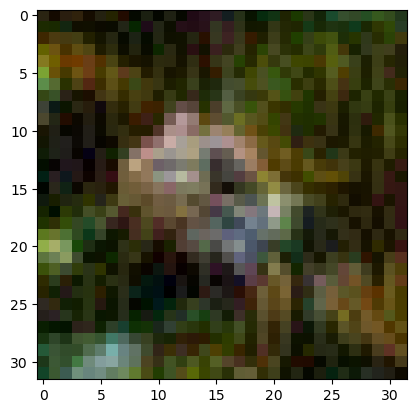

predicted :  frog
Label :  frog
6
6


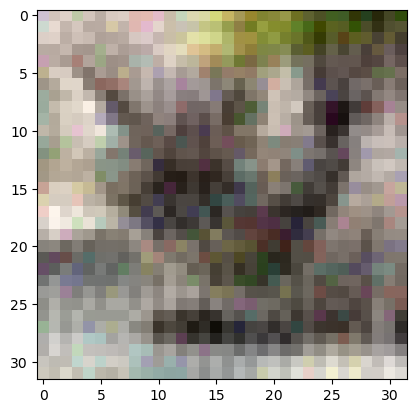

predicted :  bird
Label :  cat
2
3


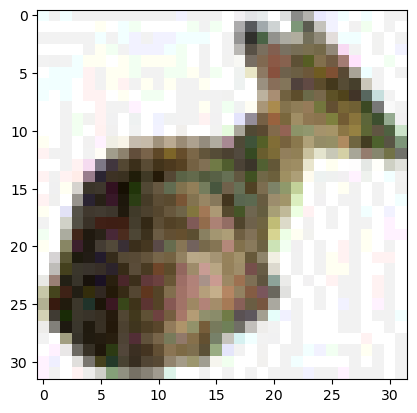

predicted :  bird
Label :  deer
2
4


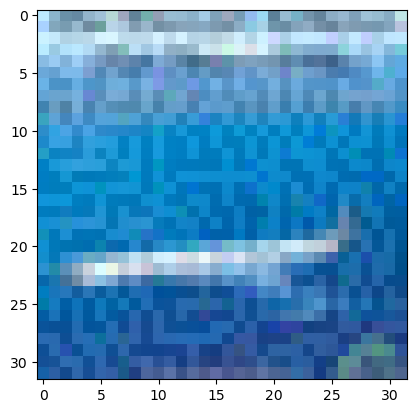

predicted :  plane
Label :  plane
0
0


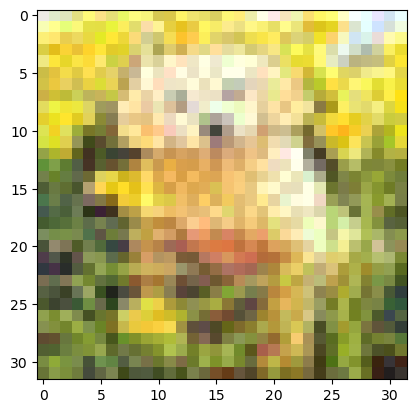

predicted :  dog
Label :  dog
5
5


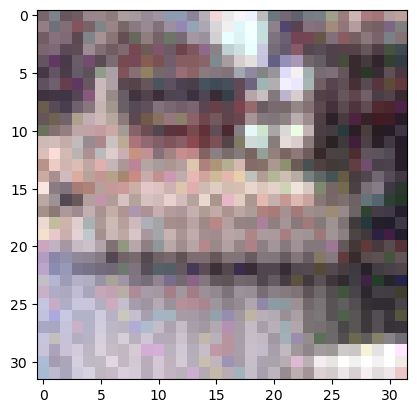

predicted :  ship
Label :  ship
8
8


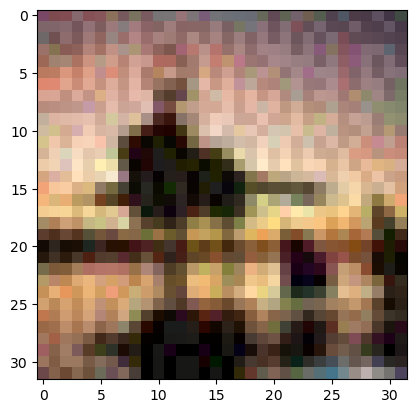

predicted :  plane
Label :  plane
0
0


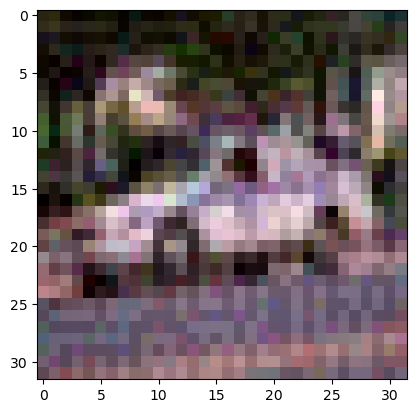

predicted :  car
Label :  car
1
1


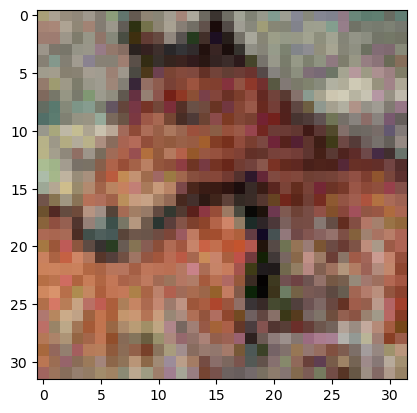

predicted :  horse
Label :  horse
7
7


KeyboardInterrupt: 

In [32]:
import time
def imageshow2(img):
    img = img.detach().cpu() if img.requires_grad else img.cpu()  # Move tensor to CPU and detach if it requires grad
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.grid(False)
    plt.show()

modified_end = []

plane = 0
car = 0
bird = 0
cat = 0
deer = 0
dog = 0
frog = 0
horse = 0
ship = 0
truck = 0
test  = transforms.Compose([transforms.ToPILImage()]) #convert to PIL Image
classesINT = [plane, car, bird, cat, deer,
           dog, frog, horse, ship, truck]
#splitting dataset in testloader to apply FGSM attack function on a specific image
for data in cifar_test_loader:
            cifar_model.eval()
            images, labels = data
            # imageshow(torchvision.utils.make_grid(images))
            images, labels = images.to(device), labels.to(device)
            output = cifar_model(images)
            _, predicted = torch.max(output, 1)
            perturbed_data = fgsm_attack(cifar_model, images, labels, epsilon=0.05 )
            for x in range(100) :
              im = torch.narrow(perturbed_data,0,x,1) #seperate into 100 images [1,3,32,32]
              imageshow2(torchvision.utils.make_grid(im)) #print each image
              print('predicted : ' , classes[predicted[x]])
              print('Label : ' , classes[labels[x]])
              print(predicted[x].item())
              print(labels[x].item())
              # saveImage(labels[x].item(),im , classesINT,'/hdd/projects/CHIA_FYP/Framework/Dataset/DenseNetDataset/FGSMOnDenseNet/FGSM2/') #set directory accordingly


GradCam Initialisation


In [33]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
from skimage.io import imread
from skimage.transform import resize

In [36]:
class GradCamModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None

        #PRETRAINED MODEL
        self.pretrained = cifar_model
        self.layerhook.append(self.pretrained.dense4.register_forward_hook(self.forward_hook()))

        for p in self.pretrained.parameters():
            p.requires_grad = True

    def activations_hook(self,grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))
        return hook

    def forward(self,x):
        out = self.pretrained(x)
        return out, self.selected_out



In [37]:
gcmodel = GradCamModel().to(device)

In [43]:
from PIL import Image
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [39]:
test_transform = transforms.Compose([transforms.ToPILImage()])
pil_image2 = test_transform(saved_tensor2.squeeze(0))
pil_image = test_transform(saved_tensor.squeeze(0))

In [48]:
from torchvision.transforms import (CenterCrop, Compose, Normalize, Resize,
                                    ToTensor)
def GradcamComparison(path): #function that takes in directory of image and prints the image + heatmap

  # img = Image.open('/content/drive/MyDrive/Colab Notebooks/Resnet50GradCamVsPixelDiff/OriginalPlane.jpg') #plane
  img  = path
  transform = Compose([Resize(32),
                         CenterCrop(32)])
  img = transform(img)
  img = np. array(img)
  orig_img  = img
  img = np.expand_dims(img.transpose((2,0,1)),0)
  img = img/255.0
  mean = np.array([0.485, 0.456, 0.406]).reshape((1,3,1,1))
  std = np.array([0.229, 0.224, 0.225]).reshape((1,3,1,1))
  img = (img - mean)/std
  inpimg = torch.tensor(img, device=device).float()
  out, acts = gcmodel(inpimg)
  acts = acts.detach().cpu()
  loss = nn.CrossEntropyLoss()(out,torch.from_numpy(np.array([out.argmax().item()])).to(device)) #0-9 ok replace np.array[x] wwith np.array[out.argmax().item()]
  torch.from_numpy(np.array([np.array(out.argmax().item())]))
  loss.backward()

  grads = gcmodel.get_act_grads().detach().cpu()

  pooled_grads = torch.mean(grads, dim=[0,2,3]).detach().cpu()

  for i in range(acts.shape[1]):
      acts[:,i,:,:] *= pooled_grads[i]
  heatmap_j = torch.mean(acts, dim = 1).squeeze()
  heatmap_j_max = heatmap_j.max(axis = 0)[0]
  heatmap_j /= heatmap_j_max
  print(heatmap_j)
  print(heatmap_j.size())
  print(heatmap_j.type())
  heatmap_j = tensor_to_image(heatmap_j)
  heatmap_j = transform(heatmap_j)
  #heatmap_j = resize(heatmap_j,(224,224),preserve_range=True)
  cmap = mpl.cm.get_cmap('jet',256)
  heatmap_j2 = cmap(heatmap_j,alpha = 0.5)
  fig, axs = plt.subplots(1,1,figsize = (5,5))
  axs.imshow((img*std+mean)[0].transpose(1,2,0))
  axs.imshow(heatmap_j2)
  plt.show()

  _, (ax_orig, ax_new) = plt.subplots(1, 2, figsize=(10.10,5.40))
  ax_new.imshow((img*std+mean)[0].transpose(1,2,0))
  ax_new.imshow(heatmap_j2)
  ax_orig.imshow(orig_img)

  ax_orig.axis("off")
  ax_new.axis("off")

  ax_orig.set_title(f"Original: ")
  ax_new.set_title(f"Heatmap: ")

  plt.savefig("res_1.png")

tensor([[ 2.2580, -3.2698, 69.8547,  1.5936],
        [ 1.6012, -3.4386, 90.5374,  3.7093],
        [ 1.4452, -2.9918, 56.3974,  2.0494],
        [ 1.0000,  1.0000,  1.0000,  1.0000]])
torch.Size([4, 4])
torch.FloatTensor


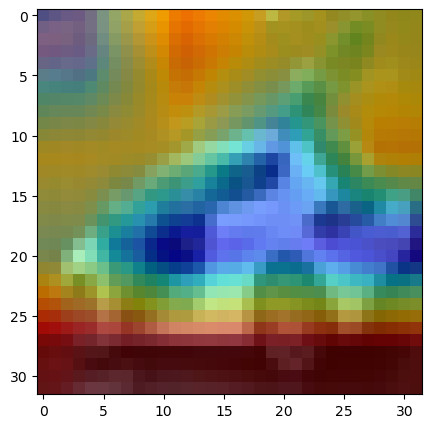

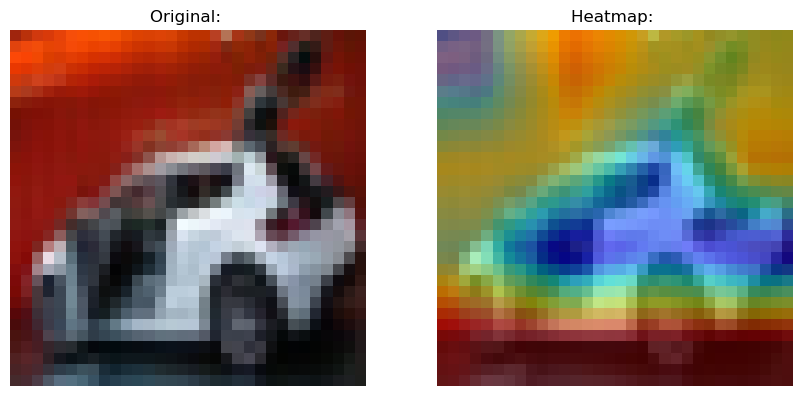

In [49]:
GradcamComparison(pil_image2)

tensor([[  3.5885,  -8.7320,   3.0358,   2.9704],
        [  5.3992, -12.7347,   5.0727,   3.7844],
        [  4.3176,  -9.5249,   2.8957,   1.4070],
        [  1.0000,   1.0000,   1.0000,   1.0000]])
torch.Size([4, 4])
torch.FloatTensor


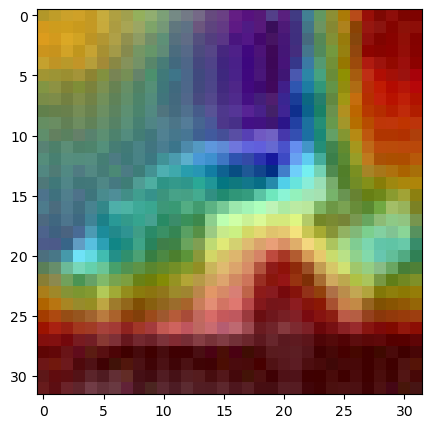

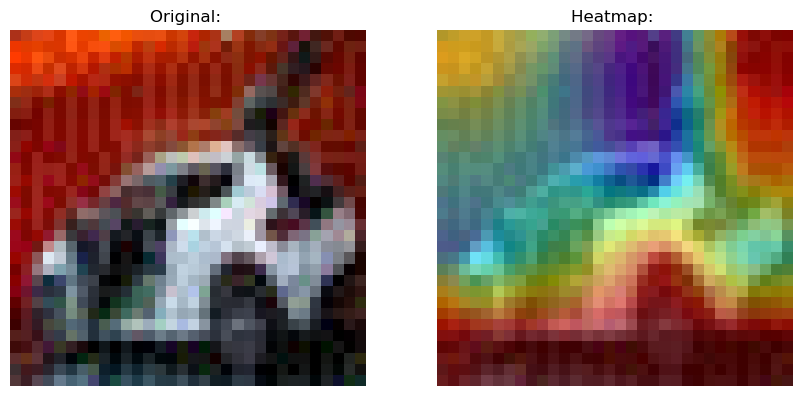

In [50]:
GradcamComparison(pil_image)

Test Accuracy of adversarial test folder

In [51]:
#change the directory to load your own pretrained model
print('==> Loading saved model for CIFAR..')
cifar_model = densenet_cifar().to(device)
cifar_model.load_state_dict(torch.load('/hdd/projects/CHIA_FYP/Framework/Models/densenet_25_Epoch.pth'))
cifar_model.eval()

==> Loading saved model for CIFAR..


DenseNet(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [52]:
modified_test = torchvision.datasets.ImageFolder(root='/hdd/projects/CHIA_FYP/Framework/Dataset/DenseNetDataset/FGSMOnDenseNet/FGSMonDenseNet' , transform=transforms.ToTensor())
modified_test_loader = torch.utils.data.DataLoader(modified_test, batch_size=100, shuffle=False, num_workers=1)
# cifar_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
# cifar_test_loader = torch.utils.data.DataLoader(cifar_test_dataset, batch_size=100, shuffle=False, num_workers=1)
# Function to test what classes performed well

def testClasses():
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    with torch.no_grad():
        for data in modified_test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            output = cifar_model(images)
            _, predicted = torch.max(output, 1)
            correct = (predicted == labels).squeeze()
            for i in range(100):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    for i in range(len(classes)):
        accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print('Accuracy of %5s : %.2f %%' % (classes[i], accuracy))

testClasses()


Accuracy of plane : 4.50 %
Accuracy of   car : 23.20 %
Accuracy of  bird : 20.50 %
Accuracy of   cat : 3.70 %
Accuracy of  deer : 22.30 %
Accuracy of   dog : 0.50 %
Accuracy of  frog : 13.70 %
Accuracy of horse : 0.30 %
Accuracy of  ship : 36.80 %
Accuracy of truck : 24.00 %


CycleGAN Model Theft

Run VisdomServer.ipnyb for visualization of training

Autocrawler for image crawling of keyword
https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [ ]:
!git clone https://github.com/YoongiKim/AutoCrawler

In [ ]:
# Fast Gradient Singed Method attack (FGSM)
#Model is the trained model for the target dataset
#target is the ground truth label of the image
#epsilon is the hyper parameter which shows the degree of perturbation

def mod_fgsm_attack(model, image, target, epsilon):
    # Set requires_grad attribute of tensor. Important for Attack
    image.requires_grad = True

    # Forward pass the data through the model
    output = model(image)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability(the prediction of the model)
    
    
   
    # If the initial prediction is already wrong, dont bother attacking
    if init_pred[0].item() != target[0].item():
    #if init_pred.item() != target.item():
        return image
    # Calculate the loss
    loss = F.nll_loss(output, target)
    # Zero all existing gradients
    model.zero_grad()
    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect datagrad
    data_grad = image.grad.data
    
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image

#This is where we test the effect of the attack on the trained model
#model is the pretrained model on your dataset
#test_loader contains the test dataset
#other parameters are set based on the type of the attack

def mod_attack_test(model, device, test_loader, epsilon, iters, attack='fgsm', alpha=1 ):

    # Accuracy counter. accumulates the number of correctly predicted exampels
    correct = 0
    adv_examples = []  # a list to save some of the successful adversarial examples for visualizing purpose
    orig_examples = []  # this list keeps the original image before manipulation corresponding to the images in adv_examples list for comparing purpose


    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        # print(target)
        # print(target[0].item())
        # print("next")
        target = torch.tensor([target])
        data = data.unsqueeze(0)
        data, target = data.to(device), target.to(device)
        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability (model prediction of the image)
       
      
        
        # Call the Attack
        if attack == 'fgsm':
            perturbed_data = mod_fgsm_attack(model, data, target, epsilon=epsilon )
        else:
            perturbed_data = ill_attack(model, data, target, epsilon, alpha, iters)
        

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        #target refers to the ground truth label
        #init_pred refers to the model prediction of the original image
        #final_pred refers to the model prediction of the manipulated image
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability (model prediction of the perturbed image)
        if final_pred[0].item() == target[0].item():  #perturbation hasn't affected the classification
            correct += 1
            
            # Special case for saving 0 epsilon examples which is equivalent to no adversarial attack
            if (epsilon == 0) and (len(adv_examples) < 534):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                orig_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred[0].item(), final_pred[0].item(), adv_ex) )
                orig_examples.append( (target[0].item(), init_pred[0].item(), orig_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 534:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                orig_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred[0].item(), final_pred[0].item(), adv_ex) )
                orig_examples.append( (target[0].item(), init_pred[0].item(), orig_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial examples and their corresponding original images
    return final_acc, adv_examples, orig_examples

In [56]:
#create train and test datasets from plane adv and plane clean
plane_clean_dataset = torchvision.datasets.ImageFolder(root='/hdd/projects/CHIA_FYP/Framework/Dataset/DenseNetDataset/FGSMOnDenseNet/AutoCrawlDenseNet/Plane_clean', transform=transforms.ToTensor())
plane_adv_dataset = torchvision.datasets.ImageFolder(root='/hdd/projects/CHIA_FYP/Framework/Dataset/DenseNetDataset/FGSMOnDenseNet/AutoCrawlDenseNet/Plane_adv', transform=transforms.ToTensor())

print("clean plane dataset length " + str(len(plane_clean_dataset)))
print("adv plane dataset length " + str(len(plane_adv_dataset)))
print("------------------seperating into train and test dataset-----------------------")
clean_test = int(len(plane_clean_dataset) * 0.1)
adv_test = int(len(plane_adv_dataset) * 0.1)
print("clean plane test dataset length " + str(clean_test))
print("adv plane dataset length " + str(adv_test))

clean plane dataset length 535
adv plane dataset length 481
------------------seperating into train and test dataset-----------------------
clean plane test dataset length 53
adv plane dataset length 48


In [ ]:
from PIL import Image
import PIL
from PIL import Image
import PIL

#modify test to folder to save image to
def saveImage(orig_prediction,tensor , classesINT):

  Unnormalize_tensor = Unnormalize(tensor) #unnormalize tensor
  Unnormalize_tensor = torch.squeeze(Unnormalize_tensor) #get rid of dim 1 . [1,32,32,3]
  test  = transforms.Compose([transforms.ToPILImage()]) #convert to PIL Image
  img = test(Unnormalize_tensor)
  # arr = to_array(Unnormalize_tensor) #convert tensor to arr  (need to check) this causes 2 times unnormalizing
  predict = classes[orig_prediction]
  test = '/hdd/projects/CHIA_FYP/Framework/Dataset/DenseNetDataset/FGSMOnDenseNet/AutoCrawlDenseNet/Plane[UnmodifiedImages]'
  out = test + predict   #/content/drive/MyDrive/FGSM/dog
  if('plane' == predict):
    run_num = classesINT[0] #get counter for img no
    image_number= out+ '/' + classes[orig_prediction] +  str(run_num) + '.jpg' #/content/drive/MyDrive/FGSM/dog/dog0
    classesINT[0]+=1
    img.save(image_number, 'JPEG')

# #modify test to folder to save image to
# def saveImage2(orig_prediction,tensor , classesINT):

#   Unnormalize_tensor = Unnormalize(tensor) #unnormalize tensor
#   Unnormalize_tensor = torch.squeeze(Unnormalize_tensor) #get rid of dim 1 . [1,32,32,3]
#   test  = transforms.Compose([transforms.ToPILImage()]) #convert to PIL Image
#   img = test(Unnormalize_tensor)
#   # arr = to_array(Unnormalize_tensor) #convert tensor to arr  (need to check) this causes 2 times unnormalizing
#   predict = classes[orig_prediction]
#   test = '/hdd/projects/CHIA_FYP/Framework/Dataset/PlaneButModifiedto[1,3,32,32]FGSM/'
#   out = test + predict   #/content/drive/MyDrive/FGSM/dog
#   if('plane' == predict):
#     run_num = classesINT[0] #get counter for img no
#     image_number= out+ '/' + classes[orig_prediction] +  str(run_num) + '.jpg' #/content/drive/MyDrive/FGSM/dog/dog0
#     classesINT[0]+=1
#     img.save(image_number, 'JPEG')

modifying images into [1,3,32,32] format while also cleaning images that are not predicted to be plans by the model.

plane
torch.Size([1, 3, 32, 32])


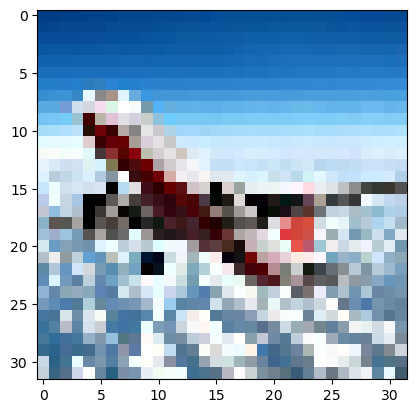

plane
torch.Size([1, 3, 32, 32])


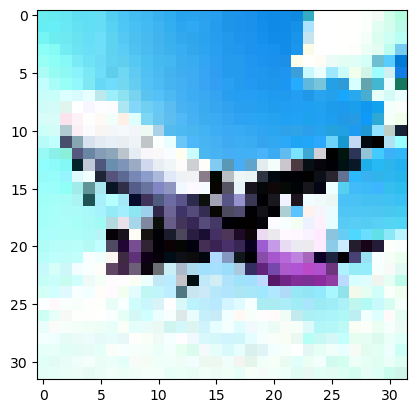

plane
torch.Size([1, 3, 32, 32])


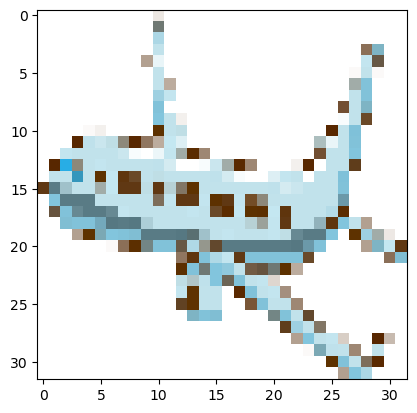

plane
torch.Size([1, 3, 32, 32])


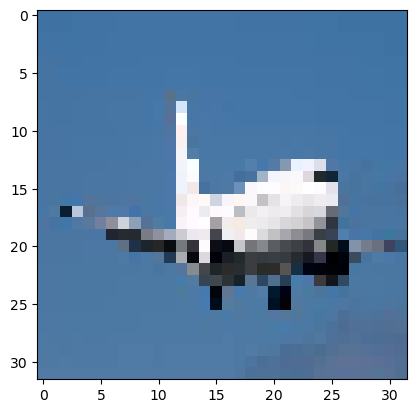

plane
torch.Size([1, 3, 32, 32])


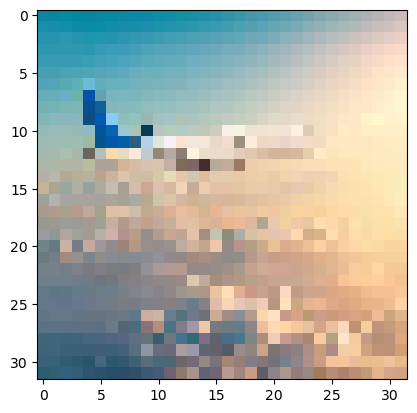

plane
torch.Size([1, 3, 32, 32])


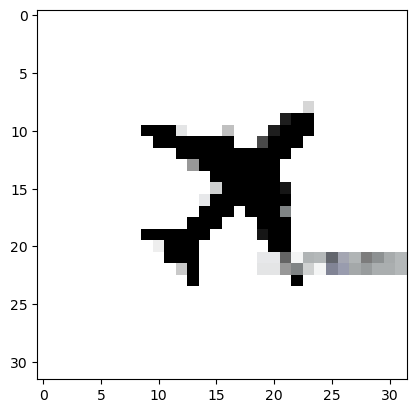

plane
torch.Size([1, 3, 32, 32])


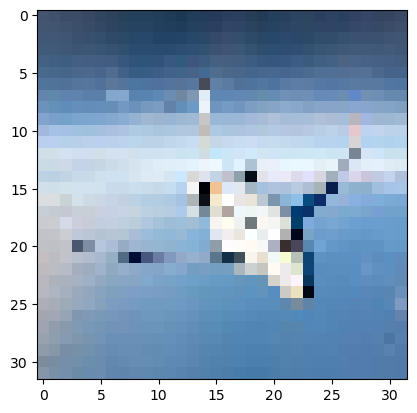

plane
torch.Size([1, 3, 32, 32])


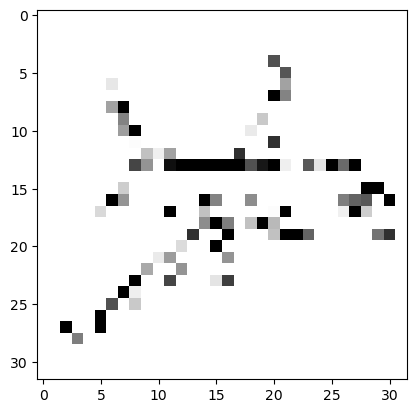

plane
torch.Size([1, 3, 32, 32])


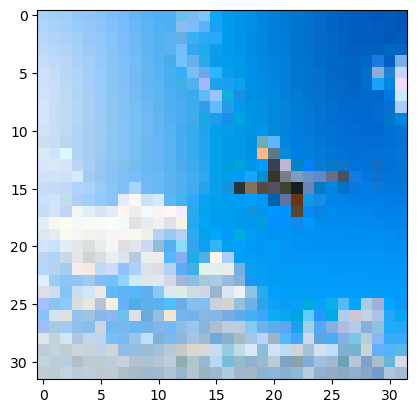

truck
plane
torch.Size([1, 3, 32, 32])


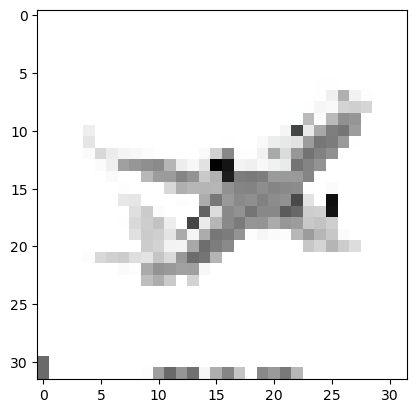

plane
torch.Size([1, 3, 32, 32])


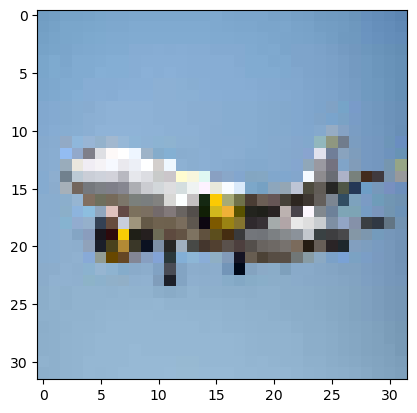

plane
torch.Size([1, 3, 32, 32])


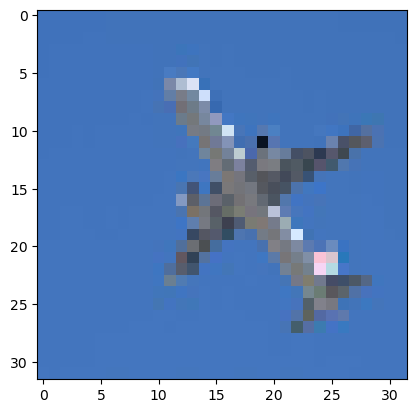

plane
torch.Size([1, 3, 32, 32])


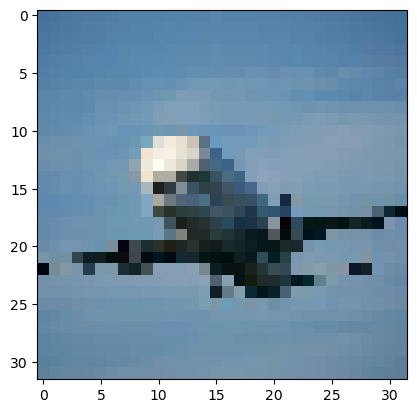

plane
torch.Size([1, 3, 32, 32])


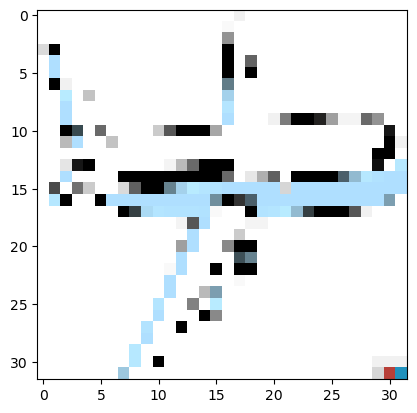

deer
plane
torch.Size([1, 3, 32, 32])


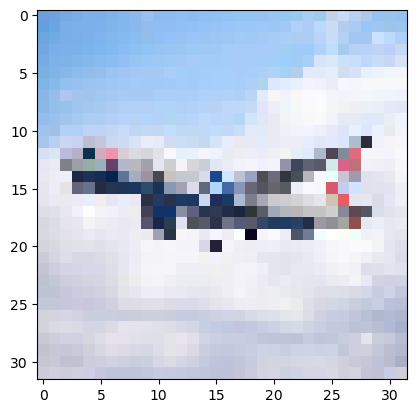

ship
plane
torch.Size([1, 3, 32, 32])


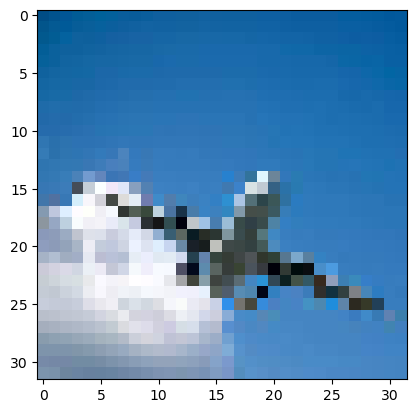

plane
torch.Size([1, 3, 32, 32])


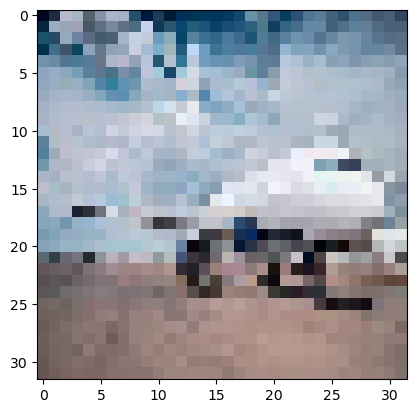

plane
torch.Size([1, 3, 32, 32])


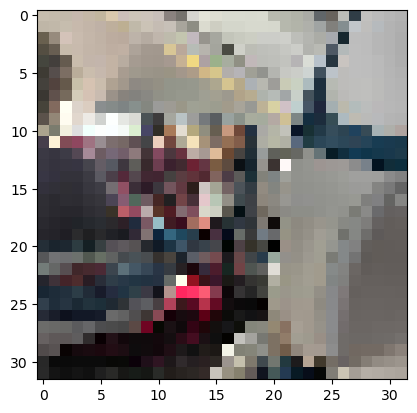

cat
plane
torch.Size([1, 3, 32, 32])


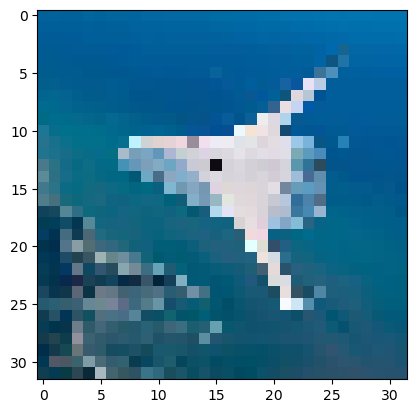

plane
torch.Size([1, 3, 32, 32])


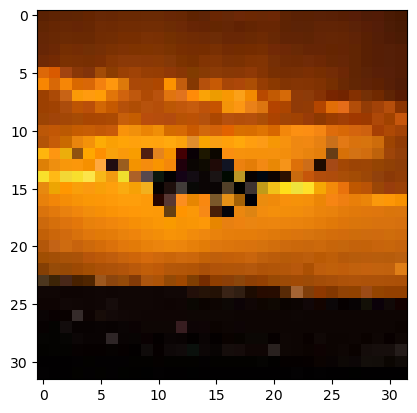

ship
plane
torch.Size([1, 3, 32, 32])


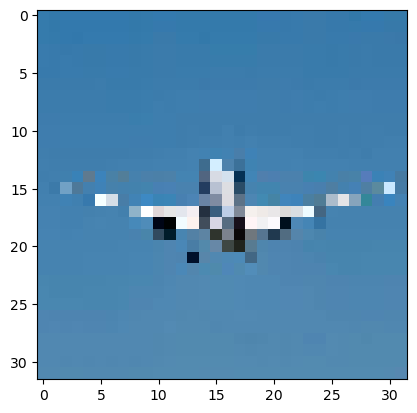

plane
torch.Size([1, 3, 32, 32])


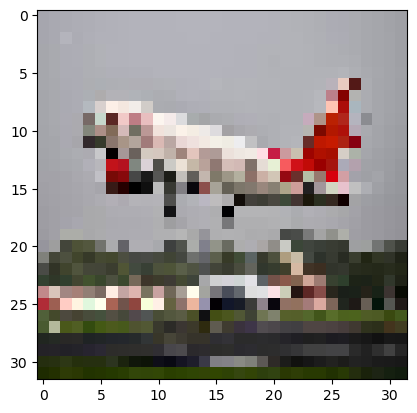

plane
torch.Size([1, 3, 32, 32])


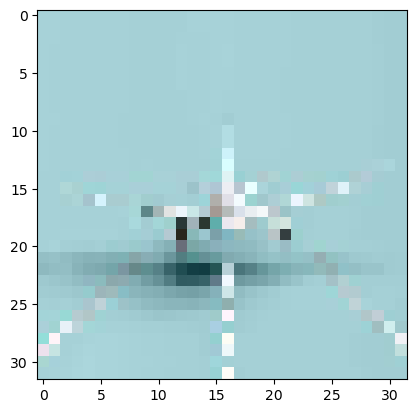

cat
plane
torch.Size([1, 3, 32, 32])


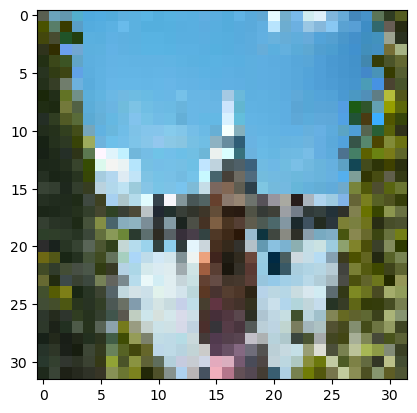

plane
torch.Size([1, 3, 32, 32])


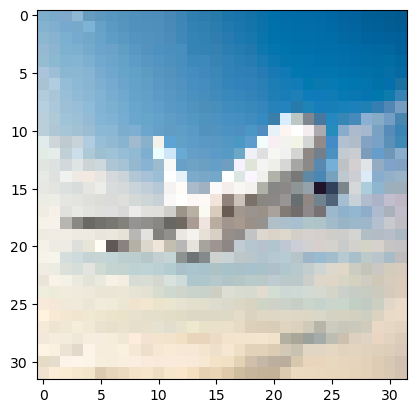

plane
torch.Size([1, 3, 32, 32])


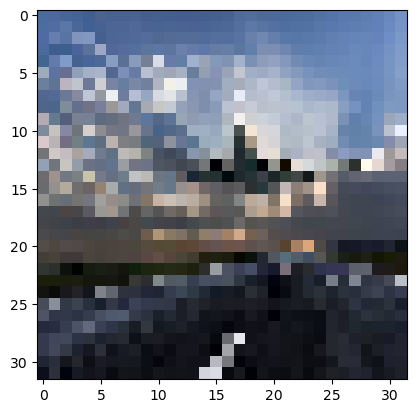

truck
plane
torch.Size([1, 3, 32, 32])


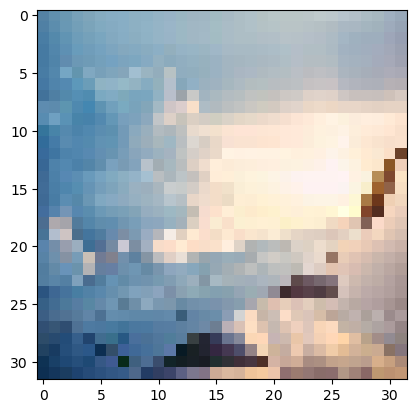

ship
bird
plane
torch.Size([1, 3, 32, 32])


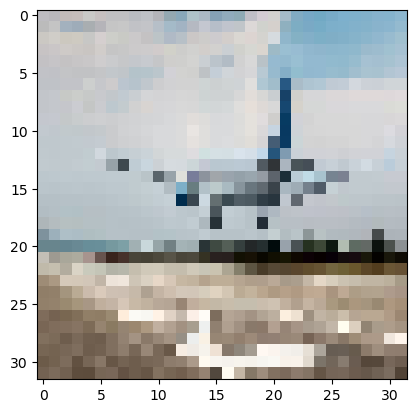

plane
torch.Size([1, 3, 32, 32])


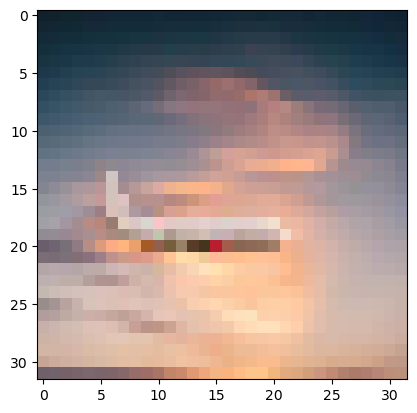

cat
plane
torch.Size([1, 3, 32, 32])


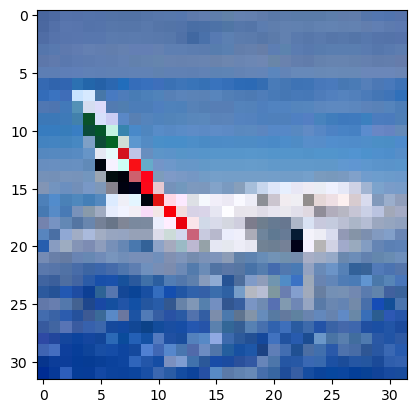

plane
torch.Size([1, 3, 32, 32])


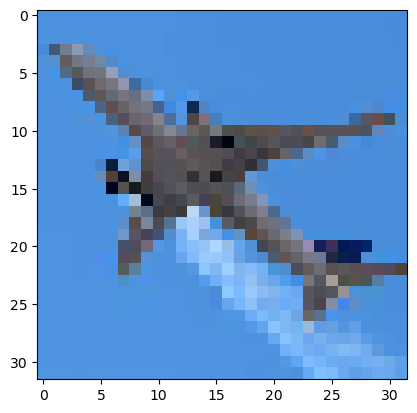

plane
torch.Size([1, 3, 32, 32])


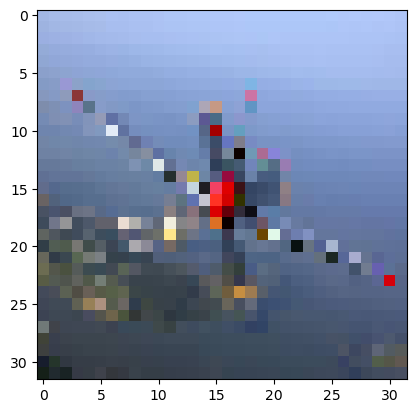

plane
torch.Size([1, 3, 32, 32])


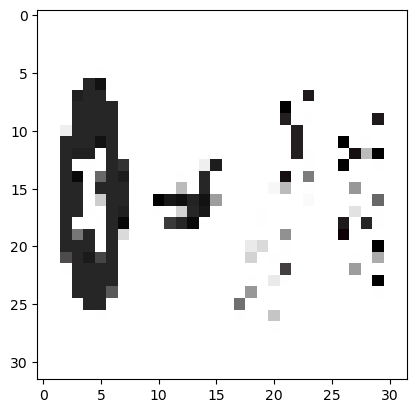

truck
plane
torch.Size([1, 3, 32, 32])


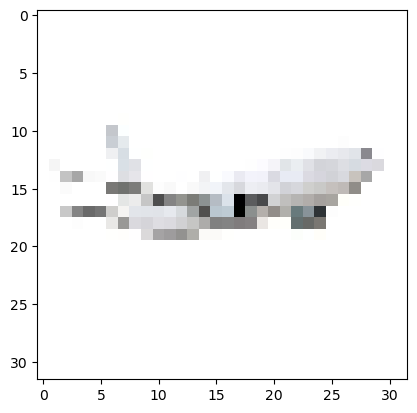

plane
torch.Size([1, 3, 32, 32])


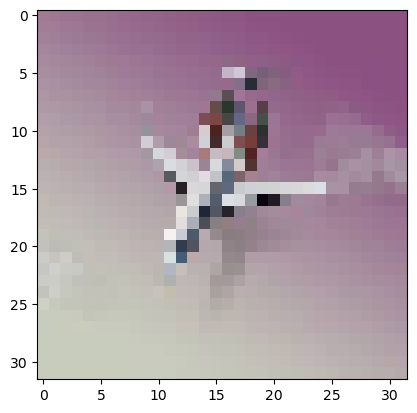

plane
torch.Size([1, 3, 32, 32])


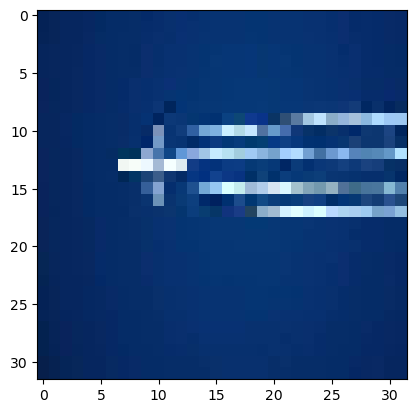

plane
torch.Size([1, 3, 32, 32])


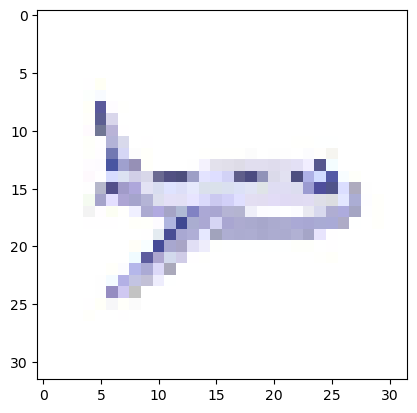

plane
torch.Size([1, 3, 32, 32])


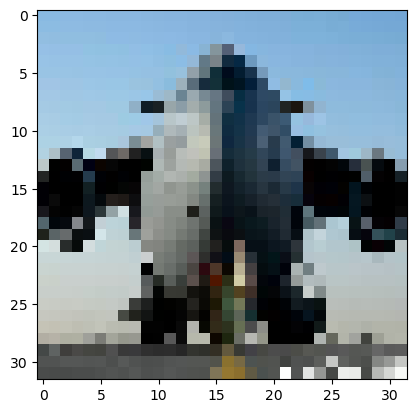

plane
torch.Size([1, 3, 32, 32])


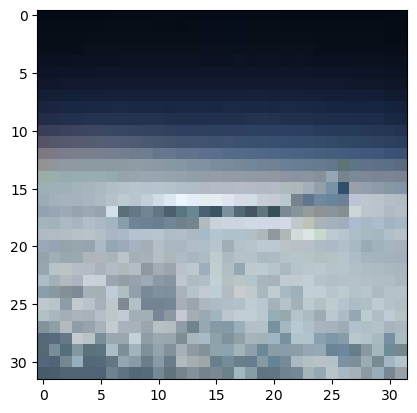

plane
torch.Size([1, 3, 32, 32])


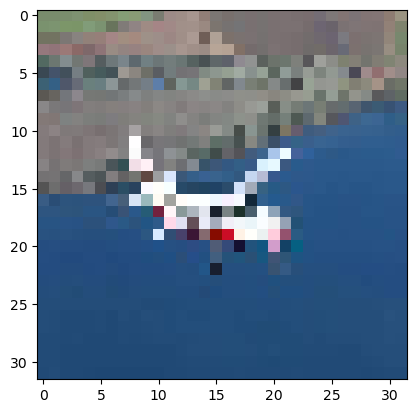

plane
torch.Size([1, 3, 32, 32])


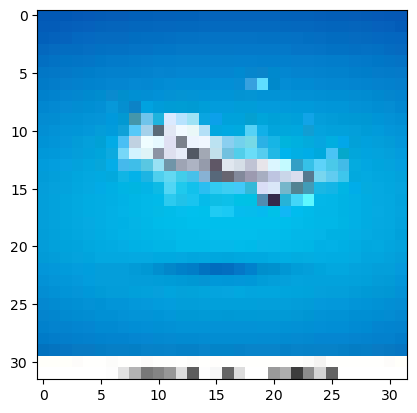

plane
torch.Size([1, 3, 32, 32])


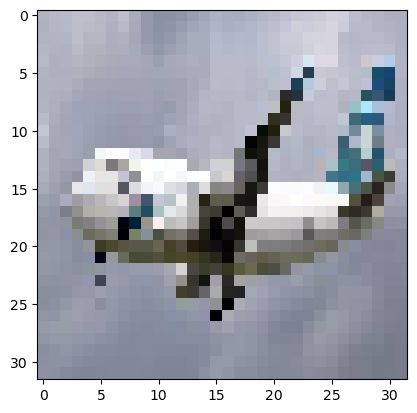

bird
plane
torch.Size([1, 3, 32, 32])


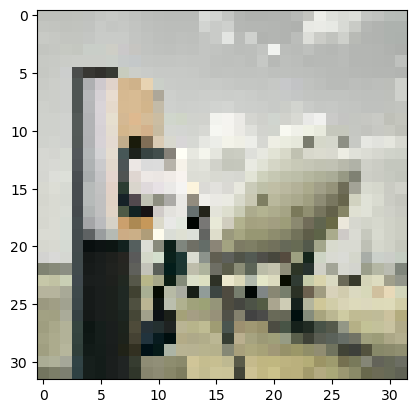

plane
torch.Size([1, 3, 32, 32])


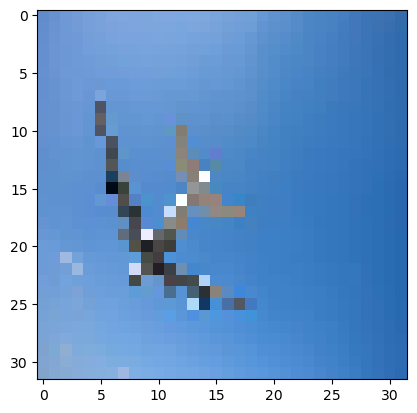

plane
torch.Size([1, 3, 32, 32])


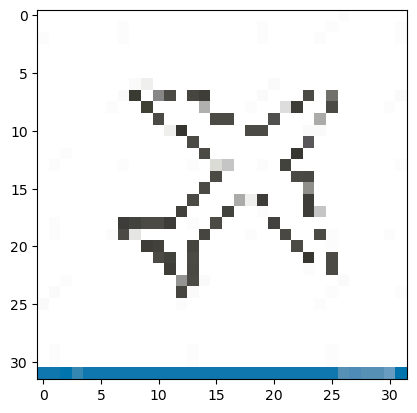

plane
torch.Size([1, 3, 32, 32])


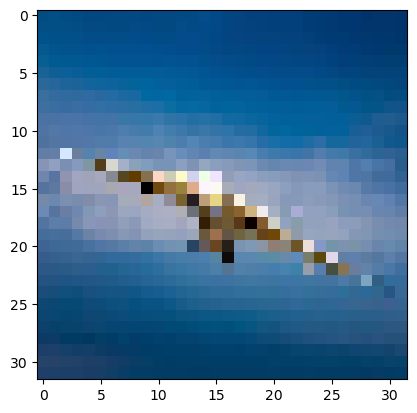

plane
torch.Size([1, 3, 32, 32])


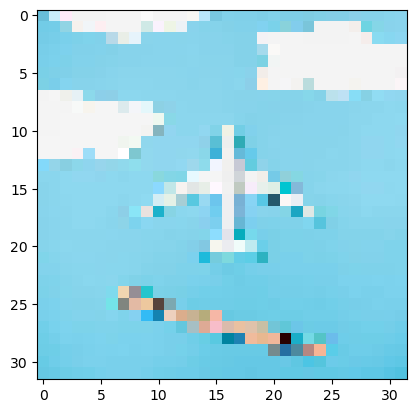

plane
torch.Size([1, 3, 32, 32])


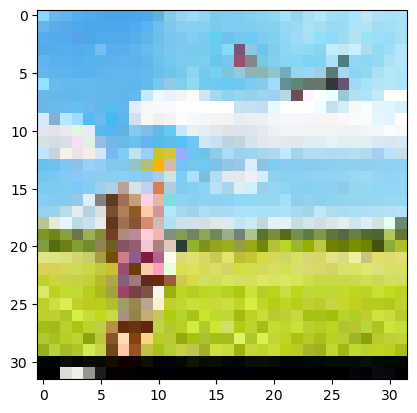

plane
torch.Size([1, 3, 32, 32])


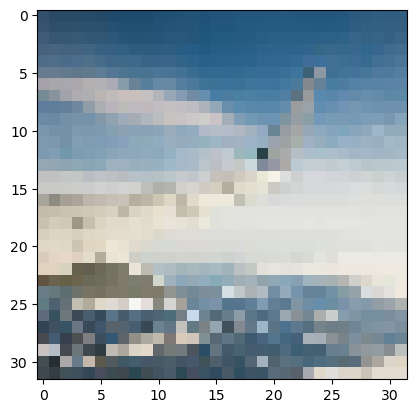

car
ship
plane
torch.Size([1, 3, 32, 32])


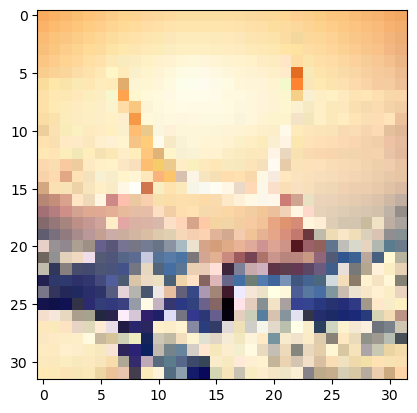

plane
torch.Size([1, 3, 32, 32])


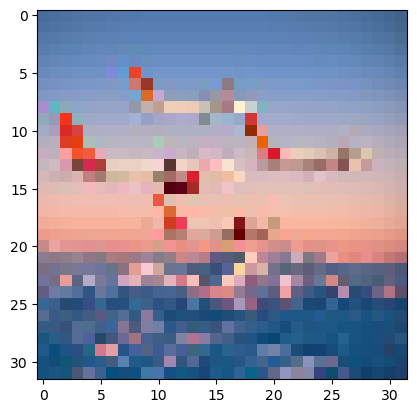

plane
torch.Size([1, 3, 32, 32])


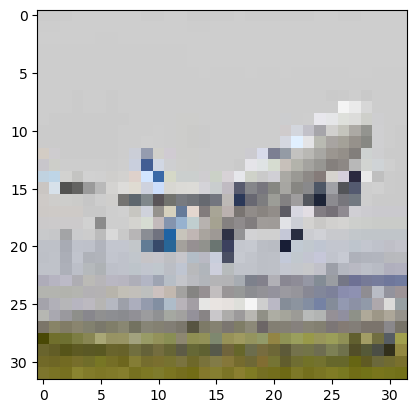

plane
torch.Size([1, 3, 32, 32])


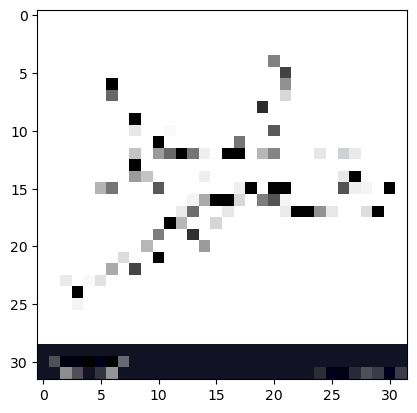

plane
torch.Size([1, 3, 32, 32])


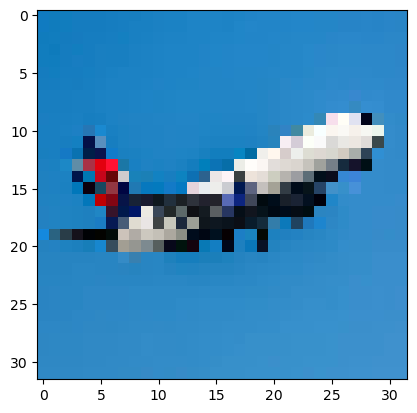

plane
torch.Size([1, 3, 32, 32])


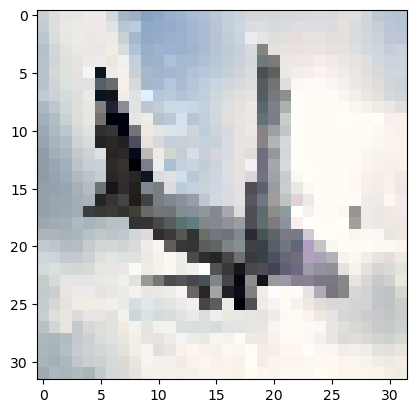

plane
torch.Size([1, 3, 32, 32])


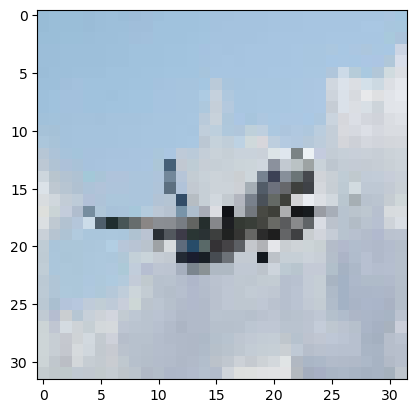

plane
torch.Size([1, 3, 32, 32])


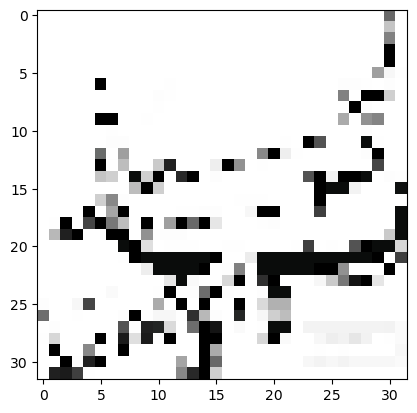

deer
plane
torch.Size([1, 3, 32, 32])


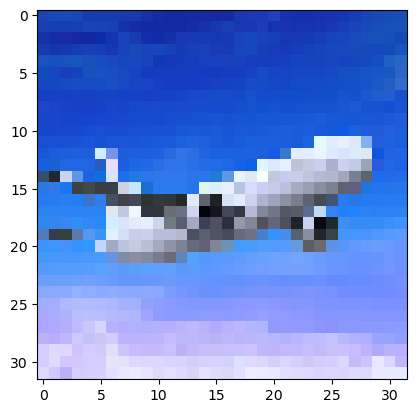

plane
torch.Size([1, 3, 32, 32])


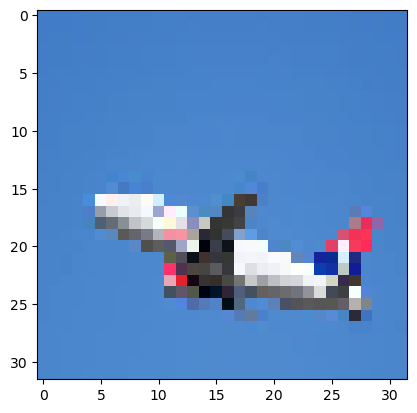

plane
torch.Size([1, 3, 32, 32])


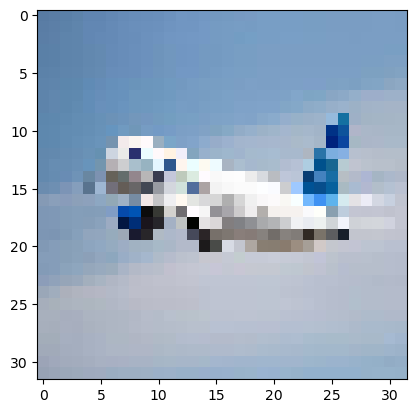

plane
torch.Size([1, 3, 32, 32])


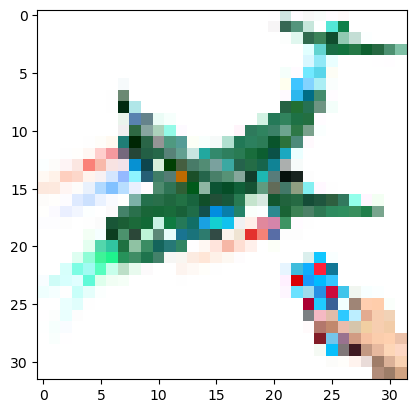

plane
torch.Size([1, 3, 32, 32])


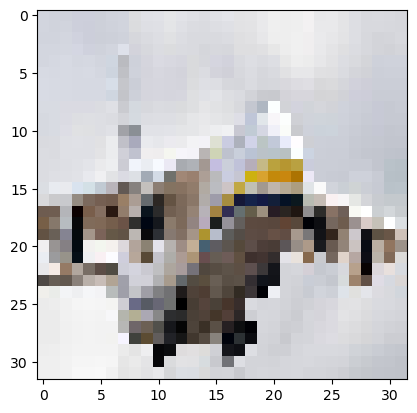

plane
torch.Size([1, 3, 32, 32])


KeyboardInterrupt: 

In [60]:
plane_dataset = torchvision.datasets.ImageFolder(root='/hdd/projects/CHIA_FYP/Framework/Dataset/DenseNetDataset/FGSMOnDenseNet/AutoCrawlDenseNet/Plane_raw/', transform=transforms.ToTensor())
running_number = 0
trans = transforms.Compose([transforms.ToTensor()] )
for image, target in plane_dataset:
        cifar_model.eval()
        # Send the data and label to the device
        # print(image.size())
        image = F.interpolate(image.unsqueeze(0), size=(32, 32), mode='nearest').squeeze(0)
        image = image[None,:,:,:]
        # imageshow(image.squeeze())
        
        # print(image.size())
        # image = image.to(device)
        # target = target.to(device)
        # Forward pass the data through the model
        output = cifar_model(image.to(device))
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability (model prediction of the image)
        # print(init_pred)
        print(classes[init_pred.item()])
        if(classes[init_pred.item()] == "plane") :
            print(image.size()) #save as 1,3,32,32 format
            numpy_im = image.squeeze().numpy()
            transposed_im = numpy_im.transpose(1,2,0)
            plt.imshow(transposed_im, cmap="gray") # in 3,32,32 format when saved
            plt.show()
            # tensortest = trans(transposed_im) 
            # print(tensortest.size())
            #saving image
            from PIL import Image
            test_transform = transforms.Compose([transforms.ToPILImage()])
            pil_image = test_transform(transposed_im)
            pil_image.save("/hdd/projects/CHIA_FYP/Framework/Dataset/DenseNetDataset/FGSMOnDenseNet/AutoCrawlDenseNet/Plane_clean/plane_" + str(running_number) + '.JPEG', 'JPEG' ) #plane_clean/plane_0 ~
            running_number = running_number + 1

Apply FGSM into folder that was just created

In [ ]:
#apply fgsm on clean plane dataset
#FGSM attack
cifar_fgsm_accuracies = [] #list to keep the model accuracy after attack for each epsilon value
cifar_fgsm_examples = [] # list to collect adversarial examples returned from the attack_test function for every epsilon values
cifar_fgsm_orig_examples = [] #list to collect original images corresponding the collected adversarial examples

# Run test for each epsilon
plane_clean_dataset = torchvision.datasets.ImageFolder(root='/hdd/projects/CHIA_FYP/Framework/Dataset/DenseNetDataset/FGSMOnDenseNet/AutoCrawlDenseNet/Plane_clean/', transform=transforms.ToTensor()) #might need to unsqeeuze each tensor in the dataset before loading the attack
for eps in fgsm_epsilons:
    cifar_model.eval()
    acc, ex, orig = mod_attack_test(cifar_model, device, plane_clean_dataset, eps, attack='fgsm', alpha=1, iters=0) 
    cifar_fgsm_accuracies.append(acc)
    cifar_fgsm_examples.append(ex)
    cifar_fgsm_orig_examples.append(orig)

In [ ]:
testing = cifar_fgsm_examples[0]
running_number=0
print(len(testing))
for x in testing:
    test = x[2]
    test = torch.from_numpy(test)
    test = test.numpy()
    transposed_im = test.transpose(1,2,0)
    plt.imshow(transposed_im, cmap="gray")
    plt.show()
    test_transform = transforms.Compose([transforms.ToPILImage()])
    pil_image = test_transform(transposed_im)
    pil_image.save("/hdd/projects/CHIA_FYP/Framework/Dataset/DenseNetDataset/FGSMOnDenseNet/AutoCrawlDenseNet/Plane_adv/plane" + str(running_number) + '.JPEG', 'JPEG' ) #plane_clean/plane_0 ~
    running_number = running_number + 1

In [53]:
#create train and test datasets from plane adv and plane clean
plane_clean_dataset = torchvision.datasets.ImageFolder(root='/hdd/projects/CHIA_FYP/Framework/Dataset/DenseNetDataset/FGSMOnDenseNet/AutoCrawlDenseNet/Plane_clean/', transform=transforms.ToTensor())
plane_adv_dataset = torchvision.datasets.ImageFolder(root='/hdd/projects/CHIA_FYP/Framework/Dataset/DenseNetDataset/FGSMOnDenseNet/AutoCrawlDenseNet/Plane_adv/', transform=transforms.ToTensor())

print("clean plane dataset length " + str(len(plane_clean_dataset)))
print("adv plane dataset length " + str(len(plane_adv_dataset)))
print("------------------seperating into train and test dataset-----------------------")
clean_test = int(len(plane_clean_dataset) * 0.1)
adv_test = int(len(plane_adv_dataset) * 0.1)
print("clean plane test dataset length " + str(clean_test))
print("adv plane dataset length " + str(adv_test))

clean plane dataset length 535
adv plane dataset length 481
------------------seperating into train and test dataset-----------------------
clean plane test dataset length 53
adv plane dataset length 48


CycleGAN Model libary

In [5]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix /hdd/projects/CHIA_FYP/Framework/CycleGANLib

Cloning into '/hdd/projects/CHIA_FYP/Framework/CycleGANLib'...
remote: Enumerating objects: 2516, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2516 (delta 0), reused 2 (delta 0), pack-reused 2513
Receiving objects: 100% (2516/2516), 8.20 MiB | 3.63 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.


In [ ]:
%cd pytorch-CycleGAN-and-pix2pix

In [ ]:
!pip install -r requirements.txt

In [ ]:
!python train.py --dataroot ./datasets/DenseNET_Plane2adv --name DenseNet_Plane2Adv_cyclegan --model cycle_gan 

In [2]:
#if continue to train from a point
!python train.py --dataroot ./datasets/DenseNET_Plane2adv --name DenseNet_Plane2Adv_cyclegan --model cycle_gan --continue_train --epoch_count 160

UnboundLocalError: local variable 'child' referenced before assignment

Function to test accuracy of the generated results from CycleGAN

In [63]:
from PIL import Image
totensor = transforms.ToTensor()

def checkAccuracy(image_number, correct_list ,original_string ,  cyclegan_string , correct,  fail ):
  if (original_string == "plane" and cyclegan_string != "plane"):
    correct = correct+1
    correct_list.append(image_number)
  else:
    fail = fail + 1
  return correct,fail

def accuracyOfGeneratedFolder():
  cifar_model.eval()
  image_number = 0
  no_of_file = 53
  correct = 0
  fail = 0
  correct_list= []
  while (image_number<no_of_file):
    string_base = "/hdd/projects/CHIA_FYP/pytorch-CycleGAN-and-pix2pix/results/DenseNet_Plane2Adv_cyclegan/test_latest/images/"
    string_path = "plane_"+ str(image_number) + "_real_A.png"
    print(string_base+string_path)
    tensor1_string = string_base + string_path
    if(os.path.exists(tensor1_string)!= True):
        image_number = image_number + 1
        continue
    img1 = Image.open(tensor1_string)
    tensor1 = totensor(img1)
    tensor1 = tensor1.unsqueeze(0)
    tensor1 = F.interpolate(tensor1, size=(32, 32), mode='nearest')
    cifar_model.eval()
    tensor1 = tensor1.to(device)
    orig_prediction = cifar_model(tensor1).argmax()
    print(f"Original Plane Image : {classes[orig_prediction.item()]}")

    string_base = "/hdd/projects/CHIA_FYP/pytorch-CycleGAN-and-pix2pix/results/DenseNet_Plane2Adv_cyclegan/test_latest/images/"
    string_path = "plane_"+ str(image_number) + "_fake_A.png"
    print(string_base+string_path)
    tensor2_string = string_base + string_path
    img2 = Image.open(tensor2_string)
    tensor2 = totensor(img2)
    tensor2 = tensor2.unsqueeze(0)
    tensor2 = F.interpolate(tensor2, size=(32, 32), mode='nearest')
    cifar_model.eval()
    tensor2 = tensor2.to(device)
    cycleGan_prediction = cifar_model(tensor2).argmax()
    print(f"Tensor was generated by CyclicGAN prediction: {classes[cycleGan_prediction.item()]}")

    string_base = "/hdd/projects/CHIA_FYP/pytorch-CycleGAN-and-pix2pix/results/DenseNet_Plane2Adv_cyclegan/test_latest/images/"
    string_path = "plane_"+ str(image_number) + "_rec_A.png"
    print(string_base+string_path)
    tensor3_string = string_base+string_path
    img3 = Image.open(tensor3_string)
    tensor3 = totensor(img3)
    tensor3 = tensor3.unsqueeze(0)
    tensor3 = F.interpolate(tensor3, size=(32, 32), mode='nearest')
    cifar_model.eval()
    tensor3 = tensor3.to(device)
    rec_prediction = cifar_model(tensor3).argmax()
    print(f"Images recreated by CyclicGan: {classes[rec_prediction.item()]}")
    correct,fail = checkAccuracy(image_number ,correct_list ,classes[orig_prediction.item()] ,  classes[cycleGan_prediction.item()] , correct,  fail )
    image_number = image_number + 1
    print(correct)
    print(fail)
  return correct,fail,correct_list

correct , fail , correct_list = accuracyOfGeneratedFolder()
accuracy  = (correct/(correct+fail)) * 100
print("number of correct = " + str(correct))
print("number of fail  = " + str(fail))
print("accuracy is  = " +  str(accuracy))
print(correct_list)

/hdd/projects/CHIA_FYP/pytorch-CycleGAN-and-pix2pix/results/DenseNet_Plane2Adv_cyclegan/test_latest/images/plane_0_real_A.png
Original Plane Image : plane
/hdd/projects/CHIA_FYP/pytorch-CycleGAN-and-pix2pix/results/DenseNet_Plane2Adv_cyclegan/test_latest/images/plane_0_fake_A.png
Tensor was generated by CyclicGAN prediction: plane
/hdd/projects/CHIA_FYP/pytorch-CycleGAN-and-pix2pix/results/DenseNet_Plane2Adv_cyclegan/test_latest/images/plane_0_rec_A.png
Images recreated by CyclicGan: plane
0
1
/hdd/projects/CHIA_FYP/pytorch-CycleGAN-and-pix2pix/results/DenseNet_Plane2Adv_cyclegan/test_latest/images/plane_1_real_A.png
Original Plane Image : plane
/hdd/projects/CHIA_FYP/pytorch-CycleGAN-and-pix2pix/results/DenseNet_Plane2Adv_cyclegan/test_latest/images/plane_1_fake_A.png
Tensor was generated by CyclicGAN prediction: ship
/hdd/projects/CHIA_FYP/pytorch-CycleGAN-and-pix2pix/results/DenseNet_Plane2Adv_cyclegan/test_latest/images/plane_1_rec_A.png
Images recreated by CyclicGan: plane
1
1
/hd

Visualization of Losses for CycleGAN Generator and Discriminator

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv('/hdd/projects/CHIA_FYP/Framework/ResNet18_Framework/resnet18cycleganloss.csv')

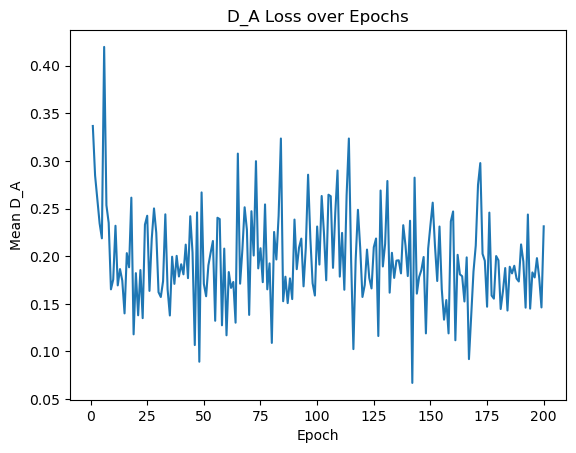

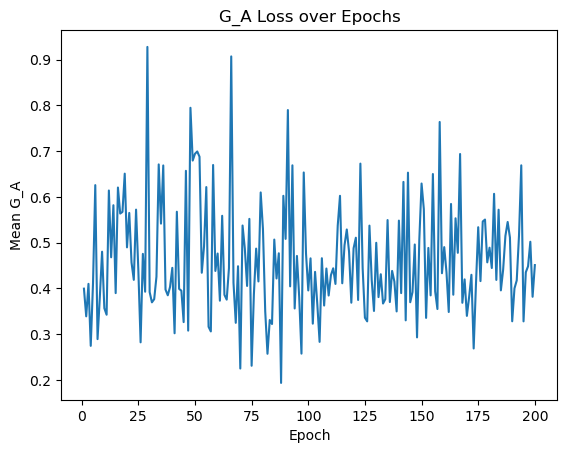

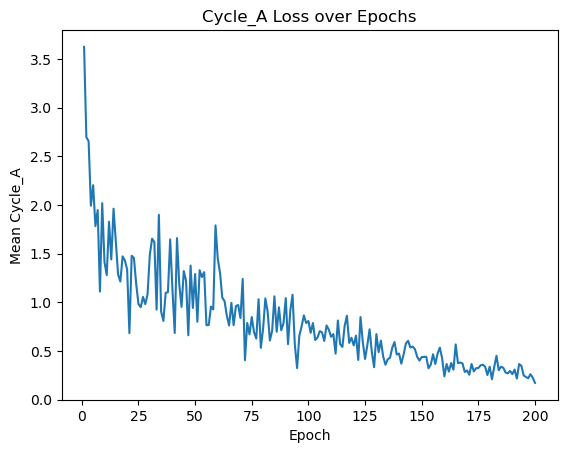

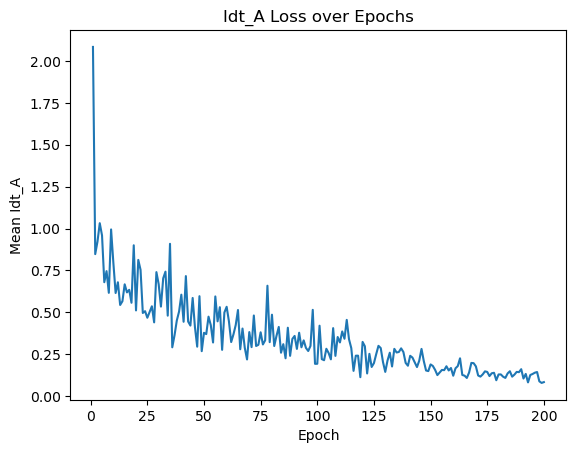

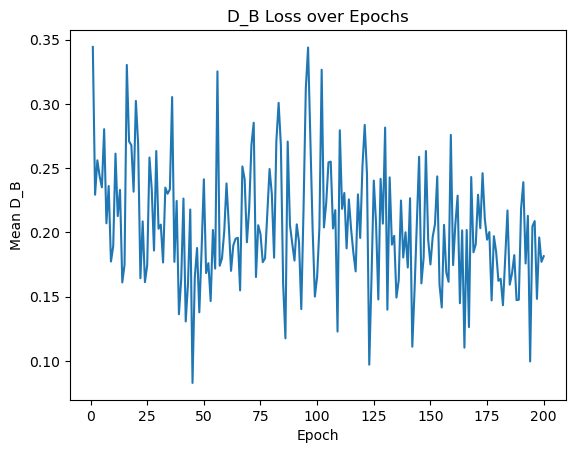

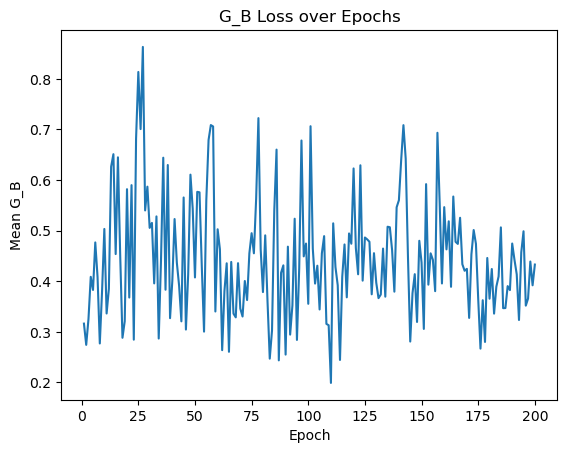

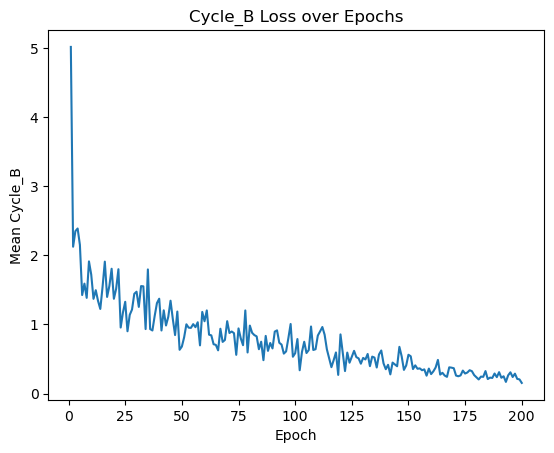

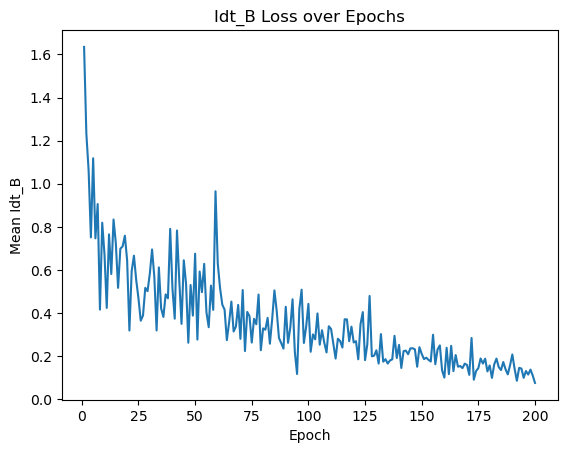

In [15]:


# Calculate mean values for each column across epochs
mean_epoch = df.groupby('Epoch').mean()

# Plot each column's mean value
for column in mean_epoch.columns:
    plt.figure()  # Create a new figure for each plot
    plt.plot(mean_epoch.index, mean_epoch[column])  # Plot the data
    plt.xlabel('Epoch')
    plt.ylabel(f'Mean {column}')
    plt.title(f'{column} Loss over Epochs')

# Show the plots
plt.show()

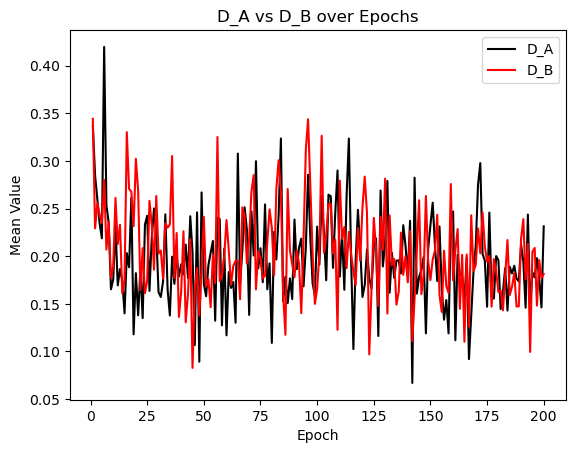

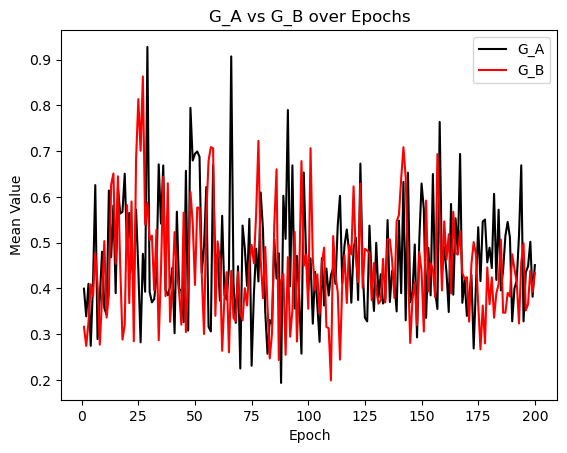

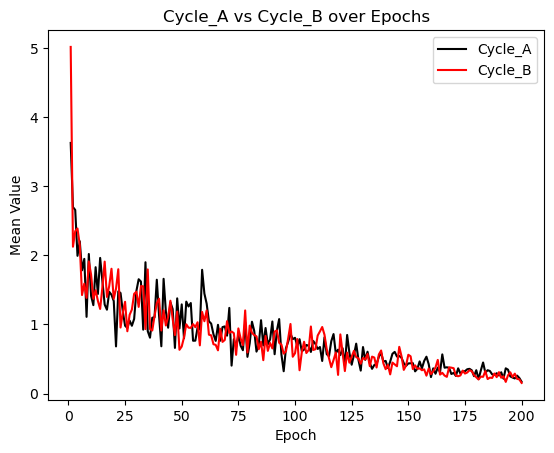

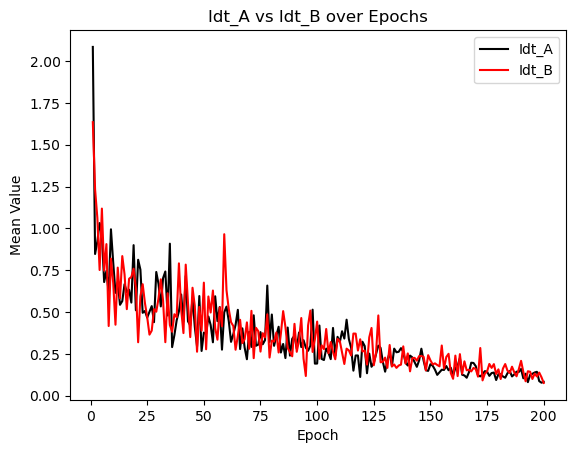

In [16]:
df.columns = df.columns.str.rstrip(':')
# Calculate mean values for each column across epochs
mean_epoch = df.groupby('Epoch').mean()

# Define pairs of columns for plotting
pairs = [('D_A', 'D_B'), ('G_A', 'G_B'), ('Cycle_A', 'Cycle_B'), ('Idt_A', 'Idt_B')]

# Plot each pair of columns
for pair in pairs:
    plt.figure()  # Create a new figure for each plot
    plt.plot(mean_epoch.index, mean_epoch[pair[0]], label=pair[0] ,  color='black')
    plt.plot(mean_epoch.index, mean_epoch[pair[1]], label=pair[1] , color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Value')
    plt.title(f'{pair[0]} vs {pair[1]} over Epochs')
    plt.legend()

# Show the plots
plt.show()